In [1]:
import pandas as pd
import numpy as np
from itertools import *

# Step 0: Business context

Business goals: Answer the following questions
1. what is the leading smartphone company
2. what model is the leading model in the word
3. what model has the best margins

-> data only has a few features. Answer these questions instead:
1. what is the most popular smartphone company, by rating
2. what is the most popular model of phone, by rating
3. what aspects of the models are popular?
-> categorized as such:
- I) brand questions
    - what is the most popular smartphone brand?
        - "Top Tiers"
        - "Consistency"
        - "Niche brands"
- II) model questions
    - what are the most popular models amongst all brands?
- III) specs questions
    - price: what is the most expensive model?
    - speed: what is the fastest model?
    - camera: what model has the best camera?
    - resolution: what model has the best resolution?
    - battery: what model has the biggest battery?

# Step 1: load in data

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment',None)
np.set_printoptions(threshold=np.inf)

def open_data(repo, file):
    with open("".join([repo, file]), "r", errors="ignore") as r:
        file = pd.read_csv(r, engine="python")
        print(file.info())
    return file

repo = r"C:/Users/benno/OneDrive/Python/Dash/Deployment_ready/smartphones/"
file = "smartphones.csv"

smart = open_data(repo, file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ï»¿brand_name              980 non-null    object 
 1   model                      980 non-null    object 
 2   price                      980 non-null    int64  
 3   avg_rating                 879 non-null    float64
 4   5G_or_not                  980 non-null    int64  
 5   processor_brand            960 non-null    object 
 6   num_cores                  974 non-null    float64
 7   processor_speed            938 non-null    float64
 8   battery_capacity           969 non-null    float64
 9   fast_charging_available    980 non-null    int64  
 10  fast_charging              769 non-null    float64
 11  ram_capacity               980 non-null    int64  
 12  internal_memory            980 non-null    int64  
 13  screen_size                980 non-null    float64

# Step 2: Summaries

In [4]:
import warnings
warnings.filterwarnings("ignore")

def summary_dataframe_small(df):

	return pd.DataFrame({'features': df.columns,'dtypes': [df.dtypes[i] for i in range(len(df.columns))],
	'nulls':[df[df.columns[i]].isnull().sum() for i in range(len(df.columns))],'nonnuls / 1.0': (df.shape[0] - 
	df.isnull().sum().values) / df.shape[0],'uniques': [df[j].nunique() for j in df.columns]})

summary_dataframe_small(smart)

features   dtypes  nulls  nonnuls / 1.0  uniques
0               ï»¿brand_name   object      0       1.000000       46
1                       model   object      0       1.000000      980
2                       price    int64      0       1.000000      379
3                  avg_rating  float64    101       0.896939       30
4                   5G_or_not    int64      0       1.000000        2
5             processor_brand   object     20       0.979592       13
6                   num_cores  float64      6       0.993878        3
7             processor_speed  float64     42       0.957143       35
8            battery_capacity  float64     11       0.988776       89
9     fast_charging_available    int64      0       1.000000        2
10              fast_charging  float64    211       0.784694       32
11               ram_capacity    int64      0       1.000000        9
12            internal_memory    int64      0       1.000000        8
13                screen_size  float64      0       1.000000       79
14               refresh_rate    int64      0       1.000000        6
15           num_rear_cameras    int64      0       1.000000        4
16                         os   object     14       0.985714        3
17        primary_camera_rear  float64      0       1.000000       18
18       primary_camera_front  float64      5       0.994898       19
19  extended_memory_available    int64      0       1.000000        2
20          resolution_height    int64      0       1.000000       65
21           resolution_width    int64      0       1.000000       40

In [5]:
def summary_dataframe_large(df):
    
    summary = pd.DataFrame({
        "feature": df.columns,
        "dtype" : [str(df[col].dtype) for col in df.columns],
        "nulls": [f"{df[col].isnull().sum()}" for col in df.columns],
        "nonnulls%": [f"{round(((1 - df[col].isnull().sum() / len(df)) * 100), 2)}%" for col in df.columns],
        "STATS": ["|" for col in df.columns],
        "min": [df[col].min().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "50%": [df[col].median().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " "for col in df.columns],
        "max": [df[col].max().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "stdev": [df[col].std().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "mean": [df[col].mean().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "skew": ["" if not any(t in str(df[col].dtype) for t in ("float", "int")) else "left" if df[col].median() > df[col].mean() else "right" if df[col].median() < df[col].mean() else "equal" for col in df.columns],
        "cat_mode": [" " if any(t in str(df[col].dtype) for t in ("float", "int")) else df[col].mode()[0] for col in df.columns],        
        "cat_mode": [" " if any(t in str(df[col].dtype) for t in ("float", "int")) else df[col].mode()[0] for col in df.columns],
        "COUNTS": ["|" for col in df.columns],
        "nuniques": [df[col].nunique() for col in df.columns],
        "vcs-": [df[col].value_counts().reset_index()["count"].min() for col in df.columns],
        "vcs+": [df[col].value_counts().reset_index()["count"].max() for col in df.columns],
        "RANDOM": ["|" for col in df.columns],
        "row[random]" :[df[col].iloc[np.random.randint(len(df))].round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else df[col].iloc[np.random.randint(len(df))] for col in df.columns],
    })

    print(df.shape)

    return summary
    
summary = summary_dataframe_large(smart)
summary

(980, 22)


feature    dtype nulls nonnulls% STATS     min      50%  \
0               ï»¿brand_name   object     0    100.0%     |                    
1                       model   object     0    100.0%     |                    
2                       price    int64     0    100.0%     |    3499  19994.5   
3                  avg_rating  float64   101    89.69%     |     6.0      8.0   
4                   5G_or_not    int64     0    100.0%     |       0      1.0   
5             processor_brand   object    20    97.96%     |                    
6                   num_cores  float64     6    99.39%     |     4.0      8.0   
7             processor_speed  float64    42    95.71%     |     1.2      2.3   
8            battery_capacity  float64    11    98.88%     |  1821.0   5000.0   
9     fast_charging_available    int64     0    100.0%     |       0      1.0   
10              fast_charging  float64   211    78.47%     |    10.0     33.0   
11               ram_capacity    int64     0    100.0%     |       1      6.0   
12            internal_memory    int64     0    100.0%     |       8    128.0   
13                screen_size  float64     0    100.0%     |    3.54     6.58   
14               refresh_rate    int64     0    100.0%     |      60     90.0   
15           num_rear_cameras    int64     0    100.0%     |       1      3.0   
16                         os   object    14    98.57%     |                    
17        primary_camera_rear  float64     0    100.0%     |     2.0     50.0   
18       primary_camera_front  float64     5    99.49%     |     0.0     16.0   
19  extended_memory_available    int64     0    100.0%     |       0      1.0   
20          resolution_height    int64     0    100.0%     |     480   2400.0   
21           resolution_width    int64     0    100.0%     |     480   1080.0   

        max     stdev     mean   skew         cat_mode COUNTS  nuniques  vcs-  \
0                                               xiaomi      |        46     1   
1                                      Apple iPhone 11      |       980     1   
2    650000  39531.81  32520.5  right                       |       379     1   
3       8.9      0.74     7.83   left                       |        30    10   
4         1       0.5     0.56   left                       |         2   431   
5                                           snapdragon      |        13     1   
6       8.0      0.84     7.77   left                       |         3    36   
7      3.22      0.46     2.43  right                       |        35     1   
8   22000.0   1009.54  4817.75   left                       |        89     1   
9         1      0.35     0.85   left                       |         2   143   
10    240.0     34.28    46.13  right                       |        32     1   
11       18      2.74     6.56  right                       |         9     2   
12     1024    107.13   141.04  right                       |         8     1   
13     8.03      0.35     6.54   left                       |        79     1   
14      240     28.99    92.26  right                       |         6     1   
15        4      0.78     2.81   left                       |         4    65   
16                                             android      |         3    11   
17    200.0      33.0    50.32  right                       |        18     1   
18     60.0     10.88    16.59  right                       |        19     1   
19        1      0.48     0.63   left                       |         2   362   
20     3840    516.48  2214.66   left                       |        65     1   
21     2460    290.16  1075.85   left                       |        40     1   

    vcs+ RANDOM        row[random]  
0    134      |               oppo  
1      1      |  Xiaomi 12T Pro 5G  
2     21      |               8499  
3     60      |                8.1  
4    549      |                  1  
5    413      |             unisoc  
6    899      |                8.0 

In [6]:
smart.columns

Index(['ï»¿brand_name', 'model', 'price', 'avg_rating', '5G_or_not',
       'processor_brand', 'num_cores', 'processor_speed', 'battery_capacity',
       'fast_charging_available', 'fast_charging', 'ram_capacity',
       'internal_memory', 'screen_size', 'refresh_rate', 'num_rear_cameras',
       'os', 'primary_camera_rear', 'primary_camera_front',
       'extended_memory_available', 'resolution_height', 'resolution_width'],
      dtype='object')

In [7]:
smart.columns = ["brand", 'model', 'price', 'avg_rating', '5G_or_not',
       'processor_brand', 'num_cores', 'processor_speed', 'battery_capacity',
       'fast_charging_available', 'fast_charging', 'ram_capacity',
       'internal_memory', 'screen_size', 'refresh_rate', 'num_rear_cameras',
       'os', 'primary_camera_rear', 'primary_camera_front',
       'extended_memory_available', 'resolution_height', 'resolution_width']

In [11]:
# interested in the following columns
cols = [
    "brand", 
    "model", 
    "price", 
    "avg_rating", 
    "processor_speed", 
    "battery_capacity", 
    "primary_camera_rear", 
    "resolution_height", 
    "resolution_width"
]

In [12]:
smarts = smart[cols]

# Step 3: Feature Engineering

In [13]:
smarts["total_res"] = smarts["resolution_height"] * smarts["resolution_width"]

In [14]:
smarts = smarts.drop(["resolution_height", "resolution_width"], axis=1)

# Step 4: EDA

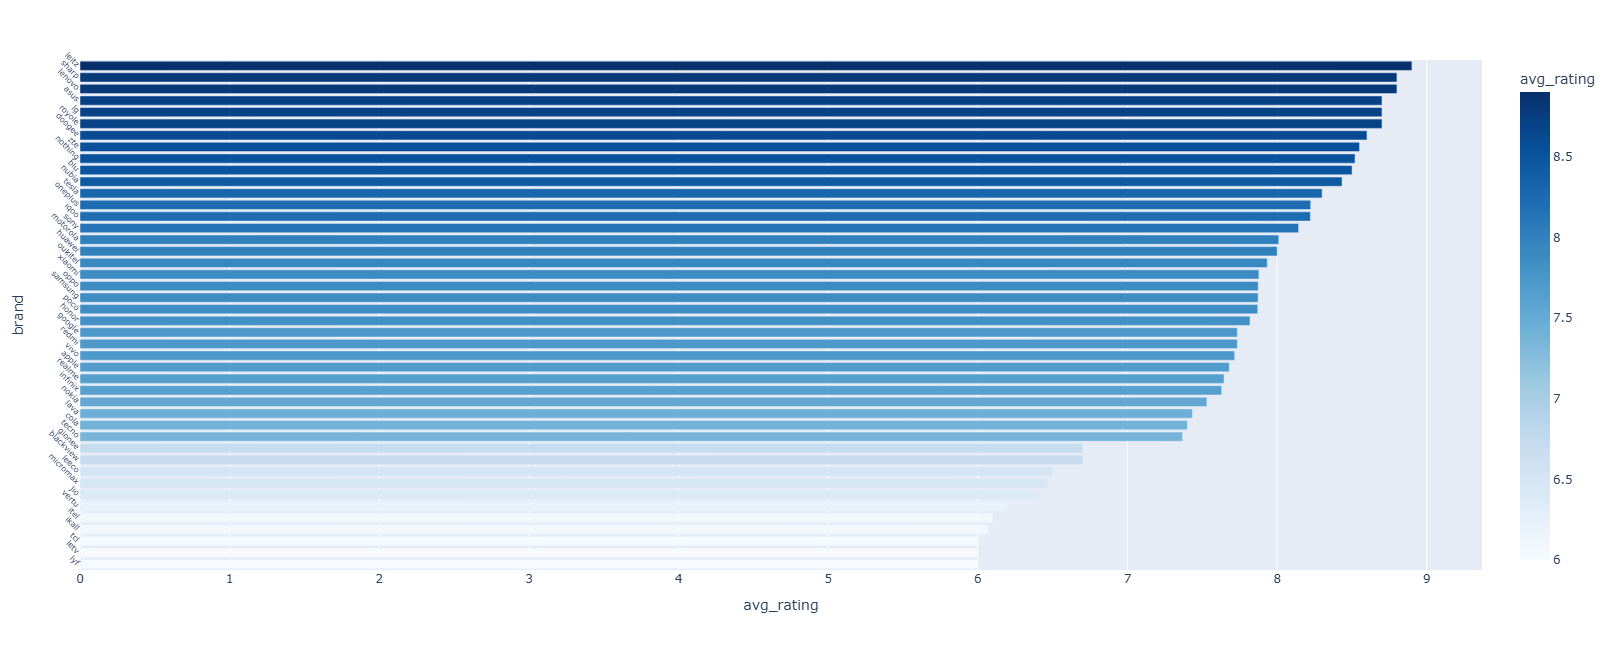

In [458]:
# truncated for final version

import plotly.io as pio
from plotly.offline import *
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

g = px.bar(gb1.dropna(), y="brand", x="avg_rating", color="avg_rating", color_continuous_scale="blues")

g.update_layout({"height": 650, 
                 "yaxis": {"tickangle": 45, "tickfont": {"size": 8}}})

# Summary of data
- Indian market
- scores range from 6.1-8.9
- hundreds of phone models
- dozens of phone brands
- many brands have a range of scores
- features are:
    - Brand
    - Model
    - Price
    - Avg rating, 1-10
    - Processor Speed
    - Battery Capcity (size)
    - Primary camera
    - Total resolution
- 980 observations
    - total shape (980, 8)
    - total size 7840
    - mostly categorical ordinal, some continuous

In [798]:
smarts.size

7840

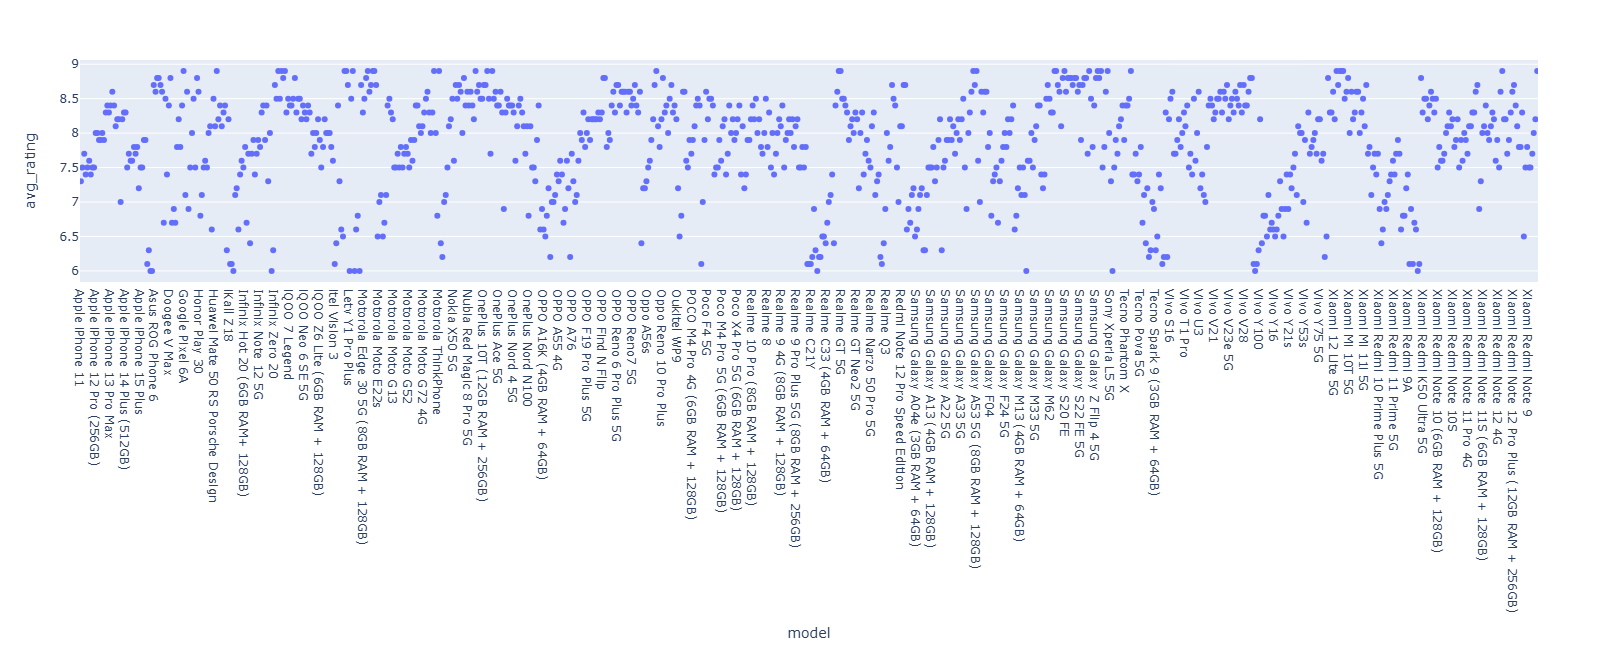

In [513]:
px.strip(gb4.dropna(), x="model", y="avg_rating").update_layout({"height": 650})

# Step 6: What are the most popular smartphones?

1. This is a ticky question. By pure mean, it's a company called Leitz. This is a German camera company, who only released one phone, and it was top-rated. Lack of sample size means the rating for the brand has stayed at that rating.

2. This analysis defines "top brand" in three ways:
- A) "Feeding frenzy" measurement: a brand's best phone (max rating, all models)
- B) "Consistency" brands: a brand's total average rating, regardless of how many phones
- C) "Niche" brands: a brand's total average rating, with population of brands with >= 10 phones
- D) "Top Tiers": brands with the most quantity of top-rated phones

### D: "Top-Tier",  most amount of maxed out phones
arrange data by brand

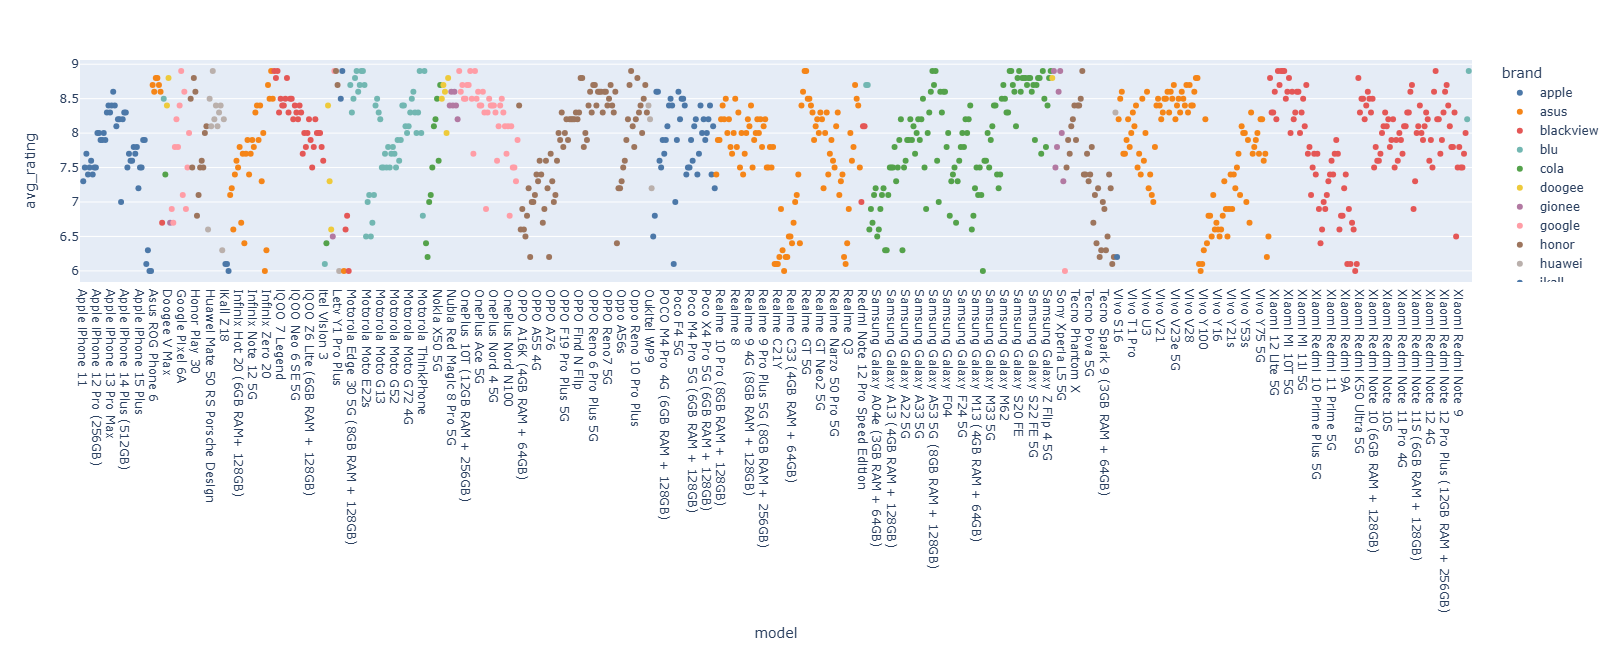

In [460]:
g = px.strip(gb4.dropna(), x="model", y="avg_rating", color="brand", color_discrete_sequence=px.colors.qualitative.T10).update_layout({"height": 650})
g

*zoom in on phones with the maxium rating*

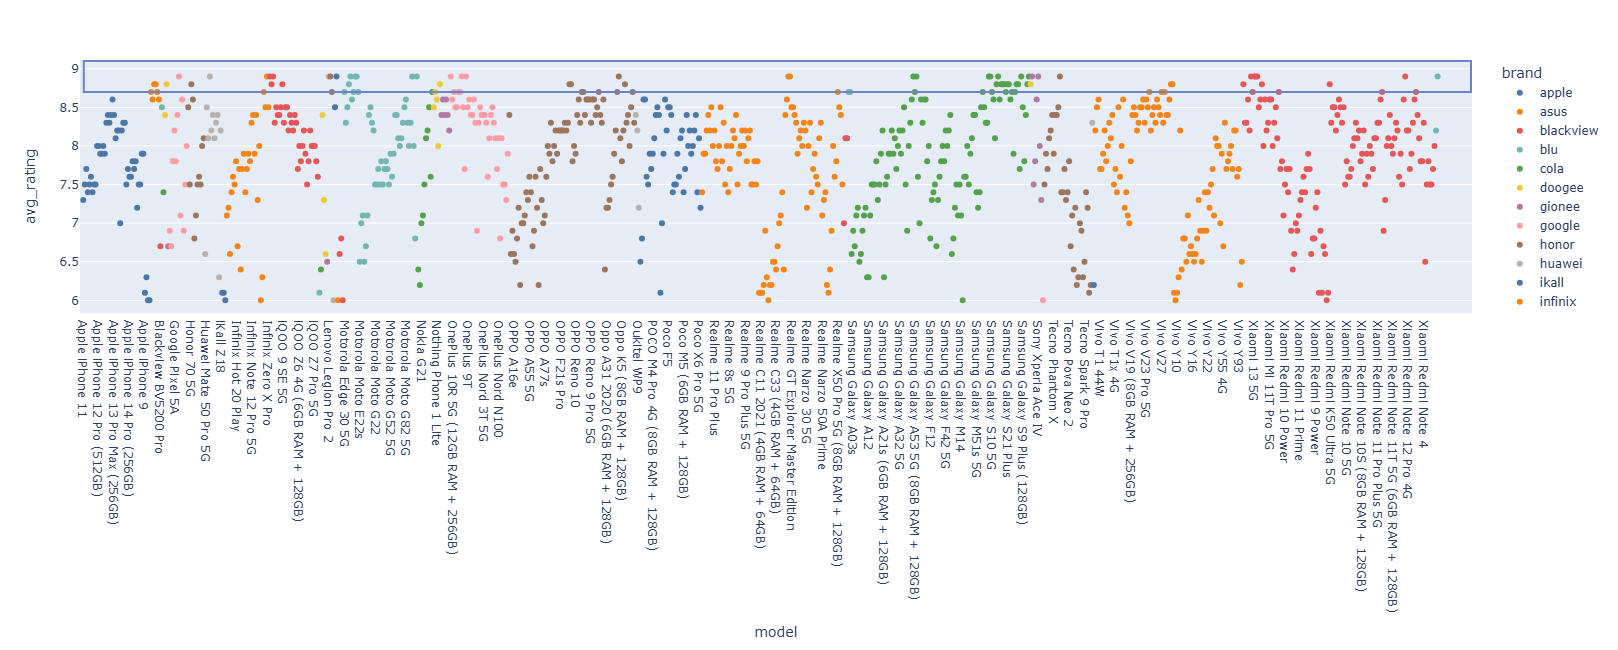

In [461]:
g.add_shape(type="rect", 
              x0=0, y0=8.7, x1=900, y1=9.1,
              line=dict(color="#6d84c8", width=2))

*many brands have top-rated phones (max rating = 8.9)*

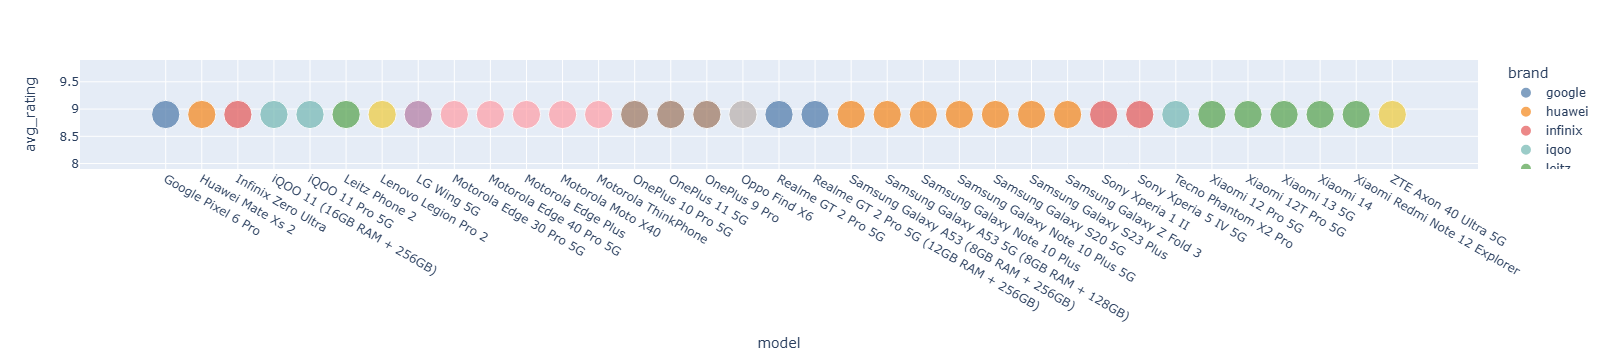

In [473]:
hr_mk = ( gb4["avg_rating"] == 8.9 )

h = px.scatter(gb4[hr_mk], x="model", y="avg_rating", size="avg_rating", color="brand", color_discrete_sequence=px.colors.qualitative.T10)
h

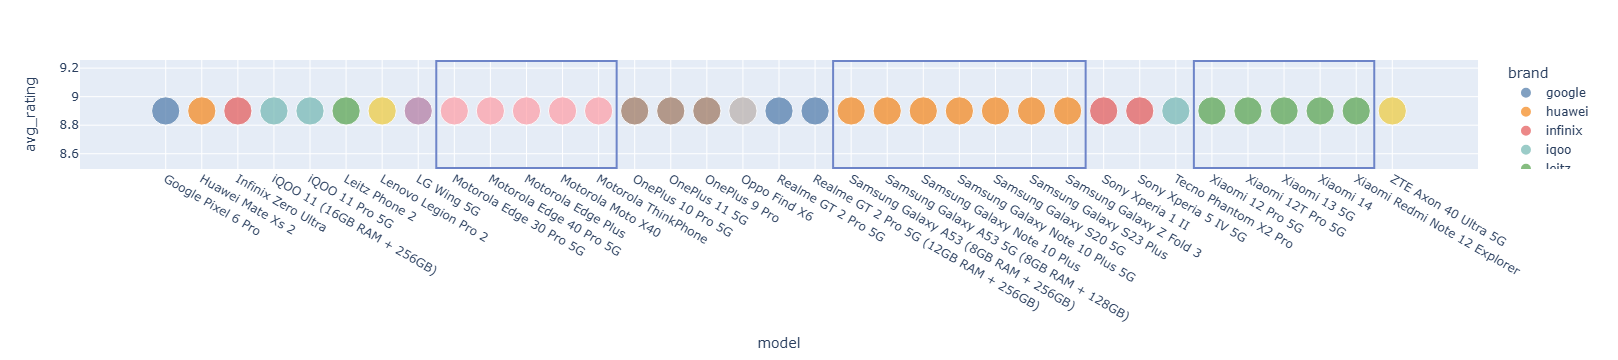

In [474]:
h.add_shape(
    type="rect",
    x0=7.5, x1=12.5,
    y0=8.5, y1=9.25,
    line={"color": "#6d84c8"},
)
h.add_shape(
    type="rect",
    x0=18.5, x1=25.5,
    y0=8.5, y1=9.25,
    line={"color": "#6d84c8"},
)
h.add_shape(
    type="rect",
    x0=28.5, x1=33.5,
    y0=8.5, y1=9.25,
    line={"color": "#6d84c8"},
)

### Answer, 1D) 
in the absence of sales data and with the inclusion of outlier brands who produce just 1 phone*, most popular smartphone brand **Top Tier**  brands are:

- ***Samsung***, with 7 top-rated phones.
- *Motorola* and *Xiaomi* come in at second
- *Oneplus* comes in at third

In [515]:
gb4[hr_mk].groupby(["brand"]).count().reset_index().sort_values(by="avg_rating", ascending=False).reset_index(drop=True)

brand  model  avg_rating
0    samsung      7           7
1   motorola      5           5
2     xiaomi      5           5
3    oneplus      3           3
4     realme      2           2
5       iqoo      2           2
6       sony      2           2
7     huawei      1           1
8         lg      1           1
9     lenovo      1           1
10     leitz      1           1
11   infinix      1           1
12    google      1           1
13      oppo      1           1
14     tecno      1           1
15       zte      1           1

### Part 1C)
Data ascending by pure mean:
- Average of all phones

In [525]:
gb1.dropna().sort_values(by="avg_rating", ascending=False)[:10].reset_index(drop=True)

brand  avg_rating
0    leitz        8.90
1   lenovo        8.80
2    sharp        8.80
3     asus        8.70
4       lg        8.70
5   royole        8.70
6   doogee        8.60
7      zte        8.55
8  nothing        8.52
9      blu        8.50

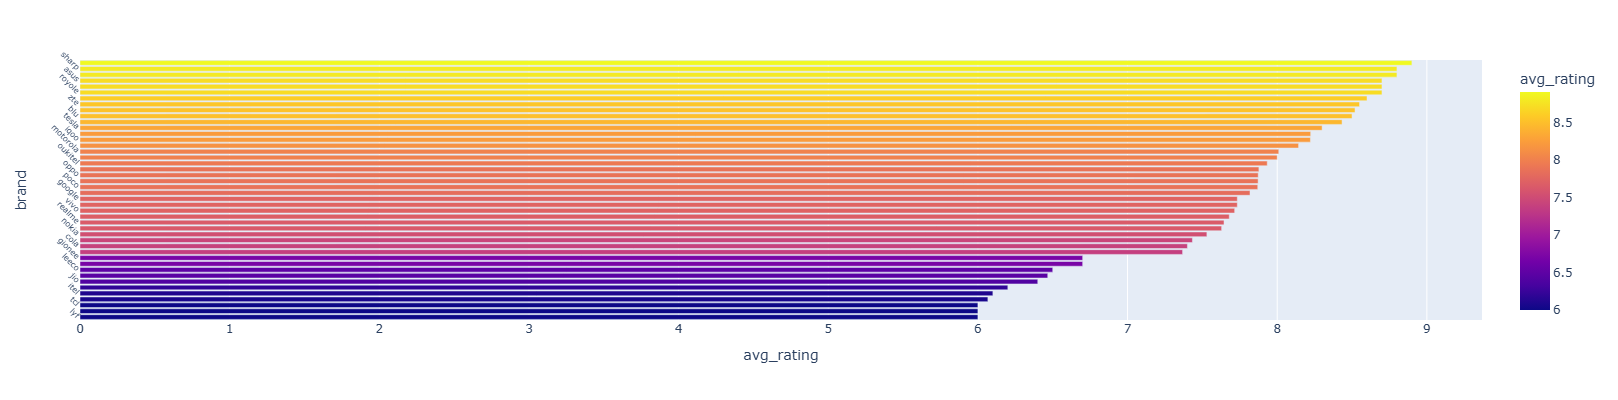

In [303]:
g = px.bar(gb1.dropna(), y="brand", x="avg_rating", color="avg_rating")

g.update_layout({"height": 400, "width": 450, 
                 "yaxis": {"tickangle": 45, "tickfont": {"size": 8}}})

*let's add in "count"*

In [524]:
gb2.sort_values(by="avg_rating_mean", ascending=False).reset_index(drop=True)[:10]

brand  count  avg_rating_mean
0    leitz      1             8.90
1   lenovo      2             8.80
2    sharp      1             8.80
3     asus      6             8.70
4       lg      2             8.70
5   royole      2             8.70
6   doogee      2             8.60
7      zte      2             8.55
8  nothing      5             8.52
9      blu      1             8.50

**We can think of these brands as an "under the radar" cohort of smartphone brands.**

**Insight**: Why is this important?
1. less homogeneity of brands creates an opportunity to for consumers to "be different" with their choice of smartphone brand
   - example: Nothing phone, "minimalist"
2. some smartphones may be ultra-specific, serving only one market niche
   - example: Doogee, battery life

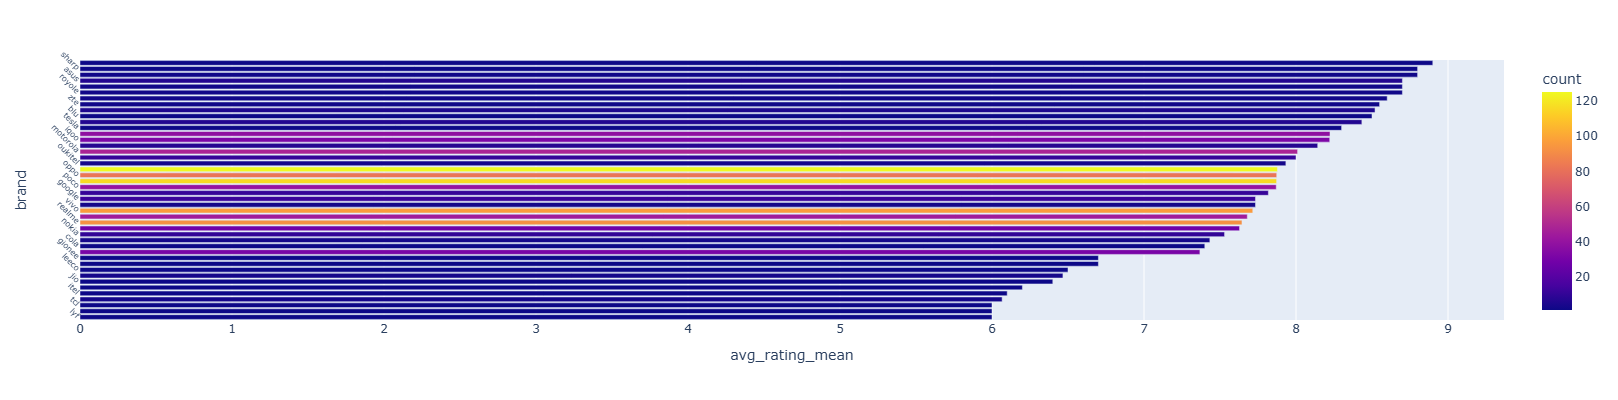

In [527]:
gb2 = smarts.groupby(["brand"]).agg({"avg_rating": ["count", "mean"]}).reset_index()
gb2.columns = ["brand", "count", "avg_rating_mean"]
gb2 = gb2.sort_values(by="avg_rating_mean", ascending=True)
g = px.bar(gb2.dropna(), y="brand", x="avg_rating_mean", color="count", color_continuous_scale="plasma")

g.update_layout({"height": 400, "width": 450, 
                 "yaxis": {"tickangle": 45, "tickfont": {"size": 8}}})

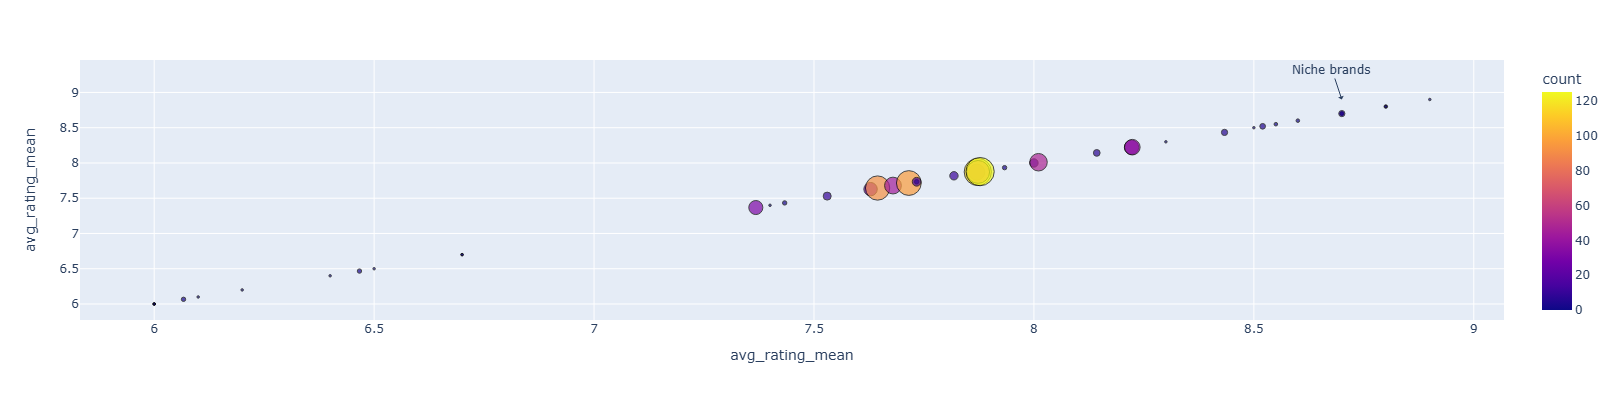

In [541]:
# some companies make significantly more phones than others, and those are the largest brands
gb2 = smarts.groupby(["brand"]).agg({"avg_rating": ["count", "mean"]}).reset_index()
gb2.columns = ["brand", "count", "avg_rating_mean"]
gb2 = gb2.sort_values(by="avg_rating_mean", ascending=True)
g = px.bar(gb2[ct_mk].dropna(), y="brand", x="avg_rating_mean", color="avg_rating_mean", color_continuous_scale=[px.colors.sequential.Plasma[-1]] * 100)

g = px.scatter(gb2, x="avg_rating_mean", y="avg_rating_mean", hover_data="brand", size="count", color="count").update_traces({"marker":{"line": {"width": 1, "color": "black"}}}).update_layout({"width": 450, "height": 400})
g.add_annotation(x=8.7, y=8.9,
            text="Niche brands",
            showarrow=True,
            arrowhead=1)

Organized into a barchart. Brands with < 10 phones.

* Remember that the "average problem" still applies. (top rated brand has only produced one phone, and it just happens to by top-rated. Doesn't mean that brand is the top smartphone maker in the market.)

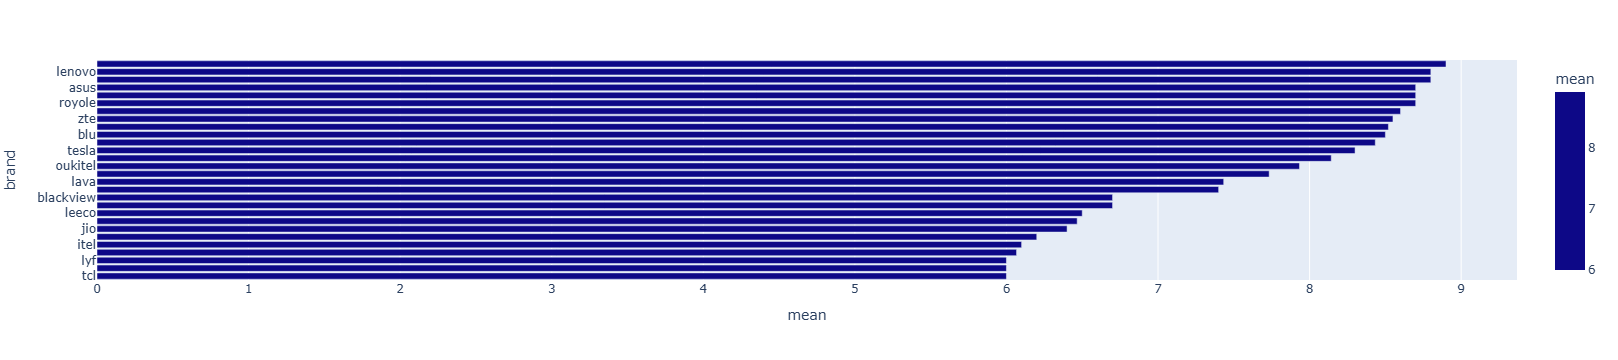

In [530]:
gb13 = smarts.groupby(["brand"]).agg({"avg_rating": ["count", "mean"]}).reset_index()
gb13.columns = ["brand", "count", "mean"]

lc_mk = ( gb13["count"] < 10 )

gb13 = gb13[lc_mk].dropna().sort_values(by="mean", ascending=False).reset_index(drop=True)
px.bar(gb13[::-1], x="mean", y="brand", color="mean", color_continuous_scale=[px.colors.sequential.Plasma[0]] * 100)

### Answer 1B)
Averaging by pure mean, and filtering for < 10 phones per brand, we uncover some "under the radar" smartphone brands. These include:
- Leitz (germany camera company)
- Nothing (minimalist new brand)
- Royale (only foldable screens)

In [549]:
gb12 = smarts.groupby(["brand"]).agg({"avg_rating": ["count", "mean"]}).reset_index()
gb12.columns = ["brand", "count", "mean"]
gb12.dropna().sort_values(by="mean", ascending=False).reset_index(drop=True)[:10]

brand  count  mean
0    leitz      1  8.90
1   lenovo      2  8.80
2    sharp      1  8.80
3     asus      6  8.70
4       lg      2  8.70
5   royole      2  8.70
6   doogee      2  8.60
7      zte      2  8.55
8  nothing      5  8.52
9      blu      1  8.50

### Answer 1B)
Averaging by pure mean, and filtering for >= 10 phones per brand, we uncover some **"Consistency"** brands in the local smartphone market. tThe best average rating is a tie between, beating out even Apple and Samsung etc, are:
- **OnePlus**
- **Iqoo**

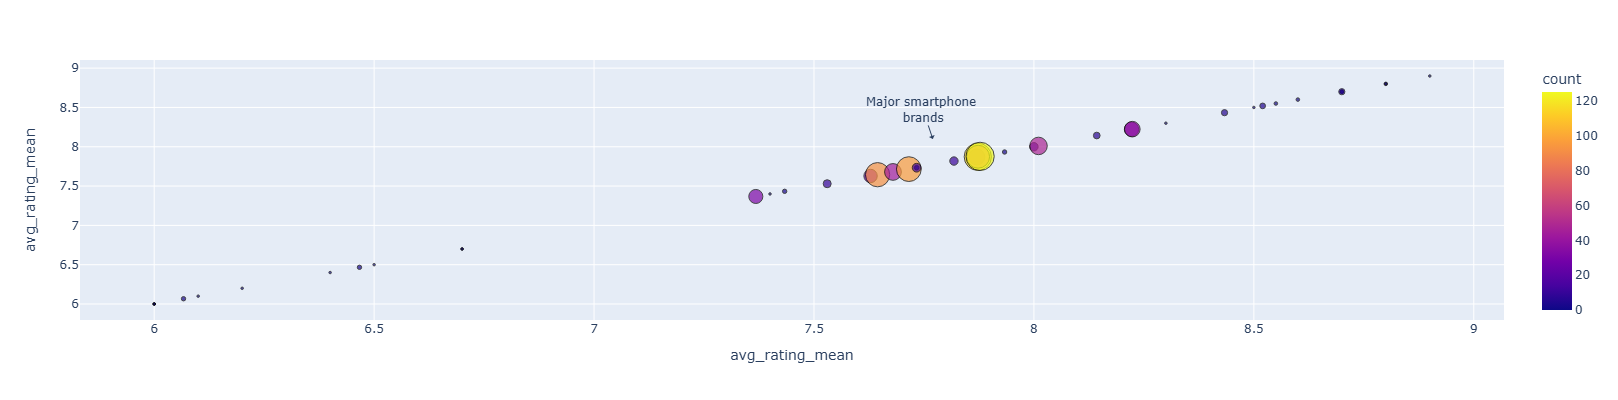

In [545]:
# some companies make significantly more phones than others, and those are the largest brands
gb2 = smarts.groupby(["brand"]).agg({"avg_rating": ["count", "mean"]}).reset_index()
gb2.columns = ["brand", "count", "avg_rating_mean"]
gb2 = gb2.sort_values(by="avg_rating_mean", ascending=True)
g = px.bar(gb2[ct_mk].dropna(), y="brand", x="avg_rating_mean", color="avg_rating_mean", color_continuous_scale=[px.colors.sequential.Plasma[-1]] * 100)

g = px.scatter(gb2, x="avg_rating_mean", y="avg_rating_mean", hover_data="brand", size="count", color="count").update_traces({"marker":{"line": {"width": 1, "color": "black"}}}).update_layout({"width": 450, "height": 400})
g.add_annotation(x=7.77, y=8.1,
            text="Major smartphone <br>brands",
            showarrow=True,
            arrowhead=1)

In [547]:
gb14 = smarts.groupby(["brand"]).agg({"avg_rating": ["count", "mean"]}).dropna().reset_index()
gb14.columns = ["brand", "count", "mean"]

hc_mk = ( gb14["count"] >= 10 )

gb14 = gb14[hc_mk]

gb14.sort_values(by="mean", ascending=False).reset_index(drop=True)[:5]

brand  count      mean
0   oneplus     38  8.223684
1      iqoo     32  8.221875
2  motorola     48  8.010417
3    huawei     11  8.000000
4    xiaomi    125  7.877600

data organized into a bar chart. The highest rated **Consistency** brands are visible quite close.
- This would be a valid answer to "best smartphone brand", as all brands are real smartphone brands (filtered for models >= 10)

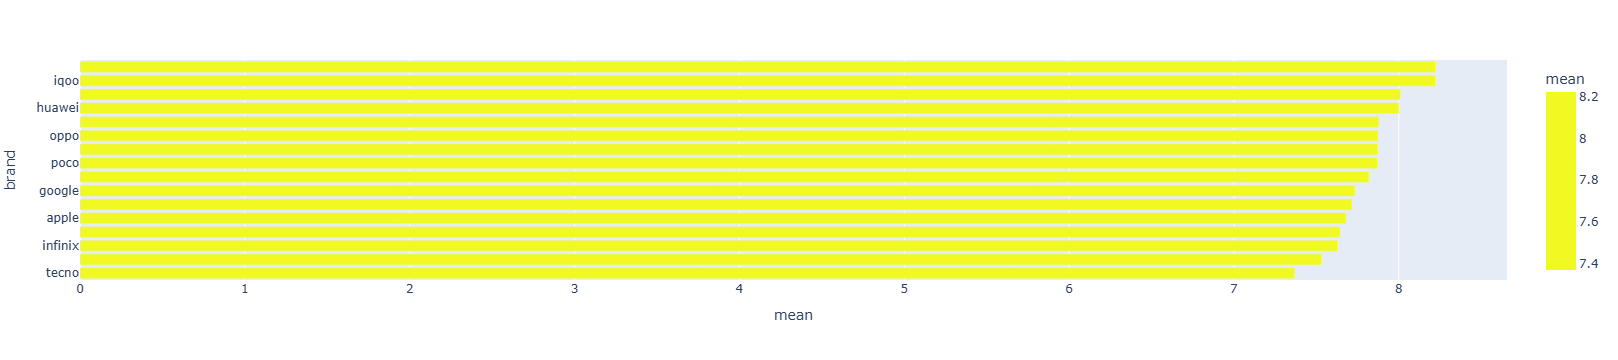

In [536]:
px.bar(gb14.sort_values(by="mean", ascending=True), y="brand", x="mean", color="mean", color_continuous_scale=[px.colors.sequential.Plasma[-1]] * 100)

In [743]:
gb14.sort_values(by="mean", ascending=False)

brand  count      mean
27   oneplus     38  8.223684
12      iqoo     32  8.221875
23  motorola     48  8.010417
9     huawei     11  8.000000
42    xiaomi    125  7.877600
28      oppo     82  7.873171
34   samsung    116  7.872414
30      poco     40  7.870000
8      honor     11  7.818182
7     google     12  7.733333
41      vivo     96  7.715625
0      apple     44  7.679545
31    realme     92  7.644565
11   infinix     28  7.628571
24     nokia     10  7.530000
38     tecno     31  7.367742

### Part 1A)
organizing by a company's best phone (max)

In [554]:
gb3.sort_values(by="avg_rating_max", ascending=False)[:20].reset_index(drop=True)[:50]

brand  count  avg_rating_max
0     realme     92             8.9
1       oppo     82             8.9
2    oneplus     38             8.9
3   motorola     48             8.9
4     lenovo      2             8.9
5      leitz      1             8.9
6         lg      2             8.9
7    samsung    116             8.9
8      tecno     31             8.9
9       sony      7             8.9
10    xiaomi    125             8.9
11       zte      2             8.9
12    google     12             8.9
13    huawei     11             8.9
14   infinix     28             8.9
15      iqoo     32             8.9
16     sharp      1             8.8
17      asus      6             8.8
18   nothing      5             8.8
19     honor     11             8.8

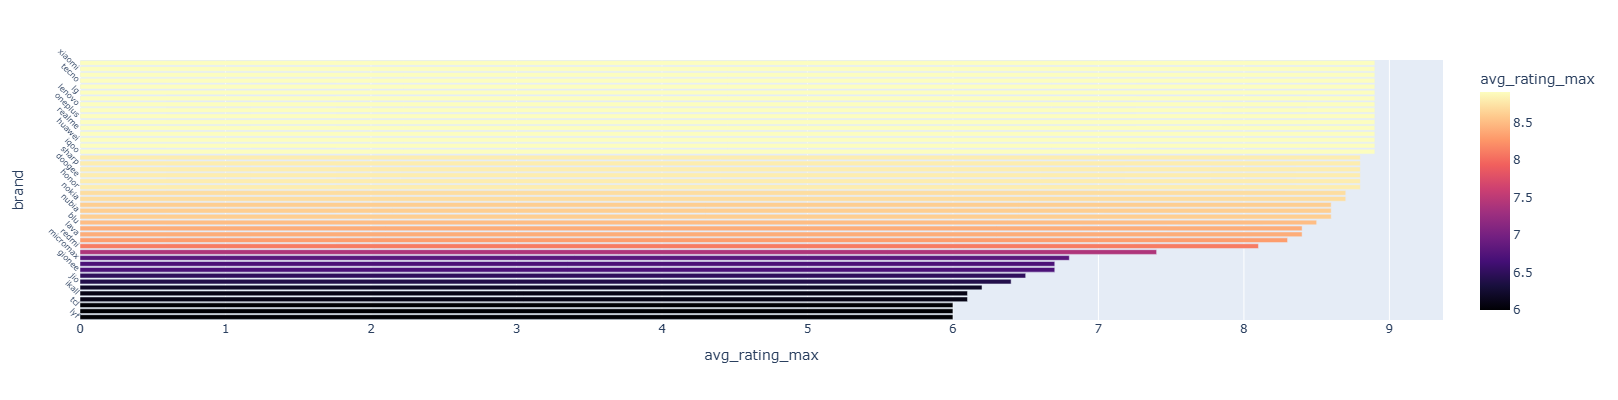

In [555]:
gb3 = smarts.groupby(["brand"]).agg({"avg_rating": ["count", "max"]}).reset_index()
gb3.columns = ["brand", "count", "avg_rating_max"]
gb3 = gb3.sort_values(by="avg_rating_max", ascending=True)
g = px.bar(gb3.dropna(), y="brand", x="avg_rating_max", color="avg_rating_max", color_continuous_scale="magma")

g.update_layout({"height": 400, "width":550, 
                 "yaxis": {"tickangle": 45, "tickfont": {"size": 8}}})

In [566]:
mx_mk =  ( gb3["avg_rating_max"] < 7 )
gb3[mx_mk]["brand"].unique()

array(['lyf', 'letv', 'tcl', 'itel', 'ikall', 'vertu', 'jio', 'leeco',
       'gionee', 'blackview', 'micromax'], dtype=object)

In [565]:
gb3.dropna().sort_values(by="avg_rating_max", ascending=False).reset_index(drop=True)

brand  count  avg_rating_max
0      realme     92             8.9
1        oppo     82             8.9
2     oneplus     38             8.9
3    motorola     48             8.9
4      lenovo      2             8.9
5       leitz      1             8.9
6          lg      2             8.9
7     samsung    116             8.9
8       tecno     31             8.9
9        sony      7             8.9
10     xiaomi    125             8.9
11        zte      2             8.9
12     google     12             8.9
13     huawei     11             8.9
14    infinix     28             8.9
15       iqoo     32             8.9
16      sharp      1             8.8
17       asus      6             8.8
18    nothing      5             8.8
19      honor     11             8.8
20       vivo     96             8.8
21     doogee      2             8.8
22      nokia     10             8.7
23     royole      2             8.7
24      apple     44             8.6
25      nubia      6             8.6
26       poco     40             8.6
27        blu      1             8.5
28       lava      3             8.4
29    oukitel      3             8.4
30      tesla      1             8.3
31      redmi      3             8.1
32       cola      1             7.4
33   micromax      3             6.8
34     gionee      1             6.7
35  blackview      1             6.7
36      leeco      1             6.5
37        jio      1             6.4
38      vertu      1             6.2
39       itel      1             6.1
40      ikall      3             6.1
41       letv      1             6.0
42        tcl      1             6.0
43        lyf      1             6.0

### Answer 1A)

there are 16 phone brands  that have at least one phone with a maxed-out rating (8.9). these include: ['iqoo','infinix', 'huawei', 'google', 'realme', 'oppo', 'oneplus',
       'motorola', 'lenovo', 'leitz', 'lg', 'samsung', 'tecno', 'sony',
       'xiaomi', 'zte']

On the flip side, there are 10 brands whose top-rated phone has a rating of < 7.0. These include: 'lyf', 'letv', 'tcl', 'itel', 'ikall', 'vertu', 'jio', 'leeco',
       'gionee', 'blackview', 'micromax'

**insight**: don't bet on any of the phone brands in the latter category
       

# Step 7: What is the most popular *model*, among all brands?

There are 980 models. Which models scored the highest?

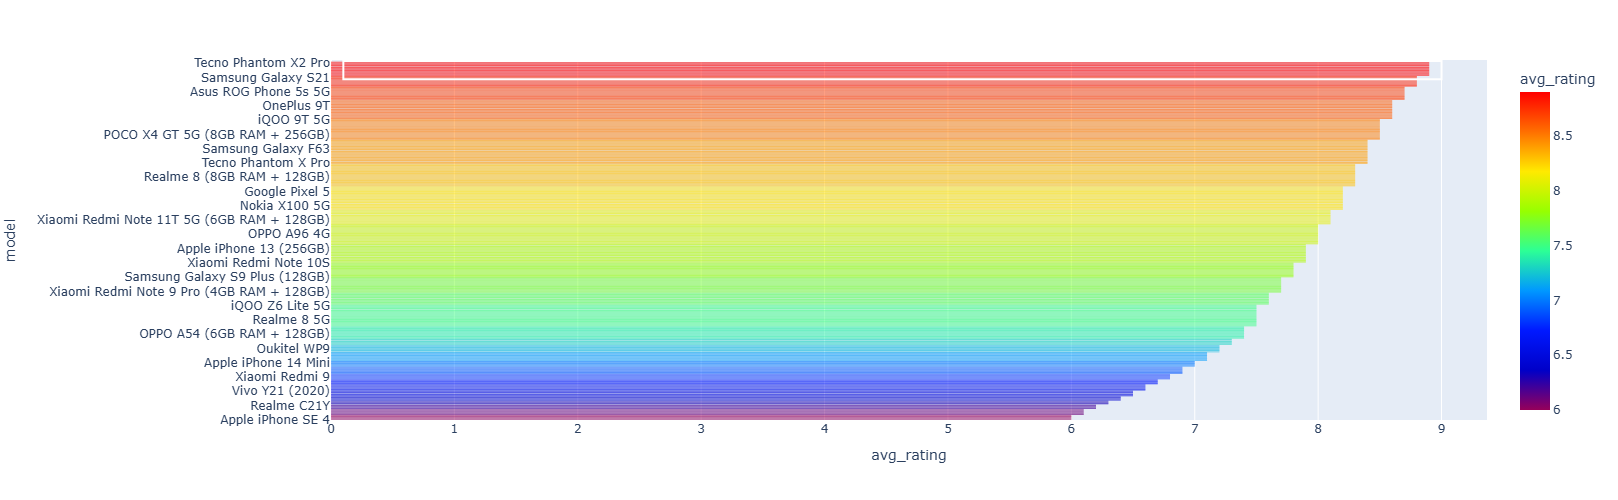

In [817]:
gb10 = smarts.groupby(["model", "brand"]).agg({"avg_rating": "mean"}).reset_index().sort_values(by="avg_rating", ascending=False)
g = px.bar(gb10[::-1].dropna(), y="model", x="avg_rating", color="avg_rating", color_continuous_scale="rainbow").update_traces(marker={"line": {"width": 0}, "opacity": 0.8})
g.add_shape(
    type="rect",
    x0=0.1, x1=9,
    y0=835, y1=880,
    line={"color": "white"}
).update_layout({"height": 500, "width": 1000})

In [806]:
# px.bar(gb10[:35][::-1].dropna(), x="model", y="avg_rating", color="avg_rating", color_continuous_scale="rainbow", range_color=[gb10["avg_rating"].min(), gb10["avg_rating"].max()]).update_traces(
#     marker={"line": {"width": 0}, "opacity": 0.8}
# ).update_layout({
#     "bargap": 0.1,
#     "height": 500, 
#     "yaxis": {"tickangle": 45, "tickfont": {"size": 9}}})

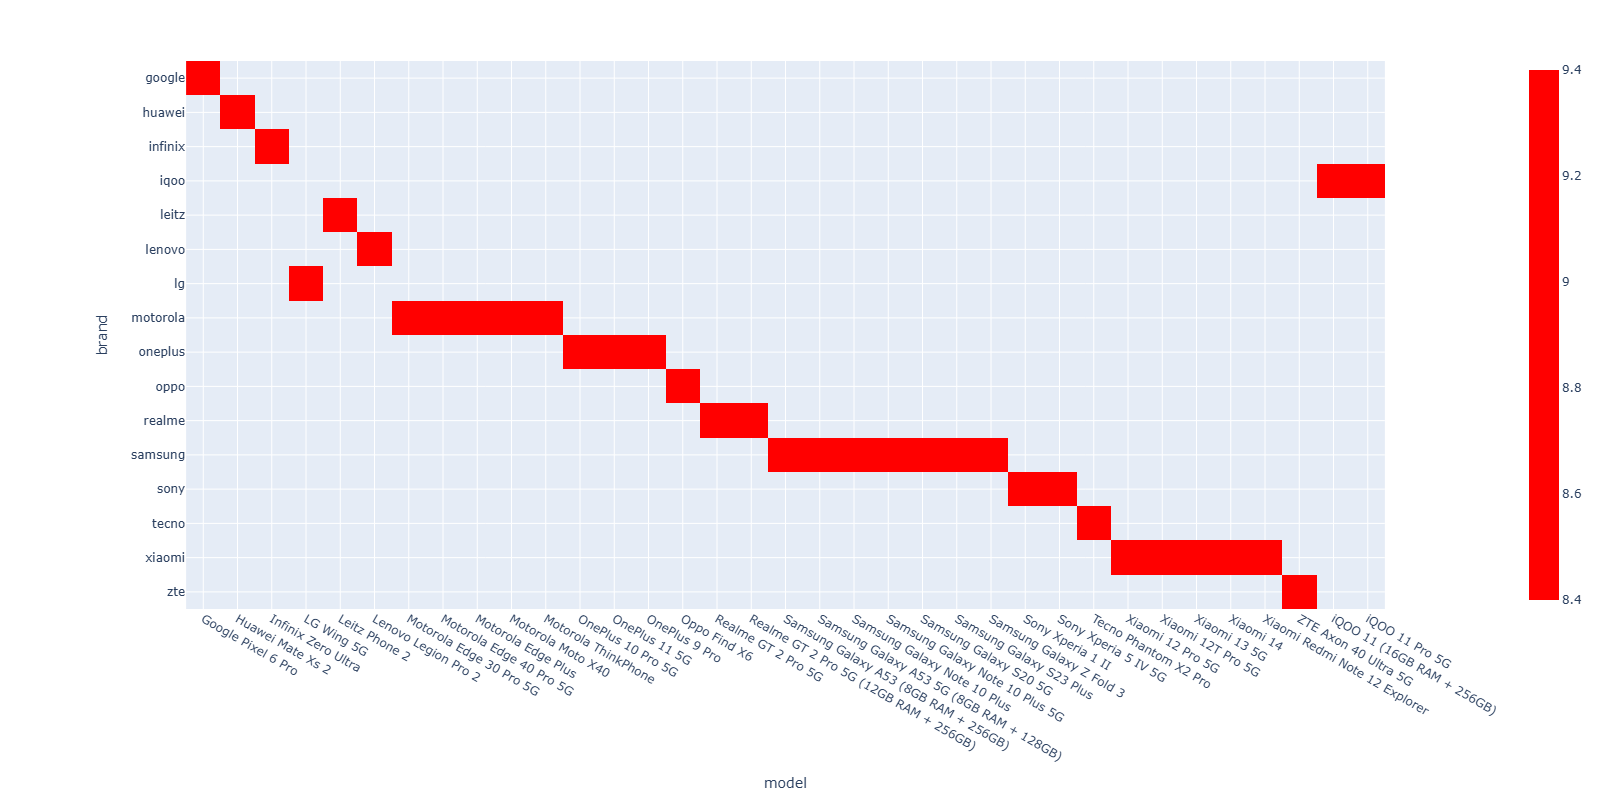

In [815]:
gb16 = smarts.groupby(["brand", "model"]).agg({"avg_rating": "mean"}).reset_index()
sm_mk = ( gb16["avg_rating"] == 8.9 )
pvt2 = gb16[sm_mk].pivot(columns="brand", index="model", values="avg_rating").T
px.imshow(pvt2, color_continuous_scale=[px.colors.sequential.Rainbow[-1]] * 100).update_layout({"height": 800, "width": 1600})

the answer is 34 way tie, from brands as above. Visual space between brands.

In [742]:
gb10[:40]

model     brand  avg_rating
354                                Oppo Find X6      oppo         8.9
635                     Samsung Galaxy S23 Plus   samsung         8.9
133                          Infinix Zero Ultra   infinix         8.9
665                        Tecno Phantom X2 Pro     tecno         8.9
650                         Sony Xperia 5 IV 5G      sony         8.9
312                               OnePlus 9 Pro   oneplus         8.9
307                               OnePlus 11 5G   oneplus         8.9
556     Samsung Galaxy A53 5G (8GB RAM + 128GB)   samsung         8.9
915               Xiaomi Redmi Note 12 Explorer    xiaomi         8.9
554        Samsung Galaxy A53 (8GB RAM + 256GB)   samsung         8.9
69                           Google Pixel 6 Pro    google         8.9
96                             Huawei Mate Xs 2    huawei         8.9
613                       Samsung Galaxy S20 5G   samsung         8.9
607              Samsung Galaxy Note 10 Plus 5G   samsung         8.9
936                        ZTE Axon 40 Ultra 5G       zte         8.9
211                         Motorola ThinkPhone  motorola         8.9
606                 Samsung Galaxy Note 10 Plus   samsung         8.9
940                  iQOO 11 (16GB RAM + 256GB)      iqoo         8.9
164                     Motorola Edge 30 Pro 5G  motorola         8.9
806                            Xiaomi 12 Pro 5G    xiaomi         8.9
811                           Xiaomi 12T Pro 5G    xiaomi         8.9
812                                Xiaomi 13 5G    xiaomi         8.9
815                                   Xiaomi 14    xiaomi         8.9
150                         Lenovo Legion Pro 2    lenovo         8.9
170                          Motorola Edge Plus  motorola         8.9
641                     Samsung Galaxy Z Fold 3   samsung         8.9
298                           OnePlus 10 Pro 5G   oneplus         8.9
470                          Realme GT 2 Pro 5G    realme         8.9
942                              iQOO 11 Pro 5G      iqoo         8.9
208                           Motorola Moto X40  motorola         8.9
471       Realme GT 2 Pro 5G (12GB RAM + 256GB)    realme         8.9
143                                  LG Wing 5G        lg         8.9
645                            Sony Xperia 1 II      sony         8.9
169                     Motorola Edge 40 Pro 5G  motorola         8.9
149                               Leitz Phone 2     leitz         8.9
275                            OPPO Find N Flip      oppo         8.8
744              Vivo X80 5G (12GB RAM + 256GB)      vivo         8.8
621  Samsung Galaxy S21 FE 5G (8GB RAM + 256GB)   samsung         8.8
619                          Samsung Galaxy S21   samsung         8.8
359                       Oppo Reno 10 Pro Plus      oppo         8.8

In [601]:
hr_mk = ( gb10["avg_rating"] == 8.9 )
len(gb10[hr_mk]) / len(gb10)

0.03571428571428571

### Answer to question 2
There are 34 models that have the highet rating, as shown the table below. **This represents 3.6% of all models.**

***Most major brands will have at least one top-rated phone.***

In [423]:
gb10.reset_index(drop=True)[:50]

model     brand  avg_rating
0                                 Oppo Find X6      oppo         8.9
1                      Samsung Galaxy S23 Plus   samsung         8.9
2                           Infinix Zero Ultra   infinix         8.9
3                         Tecno Phantom X2 Pro     tecno         8.9
4                          Sony Xperia 5 IV 5G      sony         8.9
5                                OnePlus 9 Pro   oneplus         8.9
6                                OnePlus 11 5G   oneplus         8.9
7      Samsung Galaxy A53 5G (8GB RAM + 128GB)   samsung         8.9
8                Xiaomi Redmi Note 12 Explorer    xiaomi         8.9
9         Samsung Galaxy A53 (8GB RAM + 256GB)   samsung         8.9
10                          Google Pixel 6 Pro    google         8.9
11                            Huawei Mate Xs 2    huawei         8.9
12                       Samsung Galaxy S20 5G   samsung         8.9
13              Samsung Galaxy Note 10 Plus 5G   samsung         8.9
14                        ZTE Axon 40 Ultra 5G       zte         8.9
15                         Motorola ThinkPhone  motorola         8.9
16                 Samsung Galaxy Note 10 Plus   samsung         8.9
17                  iQOO 11 (16GB RAM + 256GB)      iqoo         8.9
18                     Motorola Edge 30 Pro 5G  motorola         8.9
19                            Xiaomi 12 Pro 5G    xiaomi         8.9
20                           Xiaomi 12T Pro 5G    xiaomi         8.9
21                                Xiaomi 13 5G    xiaomi         8.9
22                                   Xiaomi 14    xiaomi         8.9
23                         Lenovo Legion Pro 2    lenovo         8.9
24                          Motorola Edge Plus  motorola         8.9
25                     Samsung Galaxy Z Fold 3   samsung         8.9
26                           OnePlus 10 Pro 5G   oneplus         8.9
27                          Realme GT 2 Pro 5G    realme         8.9
28                              iQOO 11 Pro 5G      iqoo         8.9
29                           Motorola Moto X40  motorola         8.9
30       Realme GT 2 Pro 5G (12GB RAM + 256GB)    realme         8.9
31                                  LG Wing 5G        lg         8.9
32                            Sony Xperia 1 II      sony         8.9
33                     Motorola Edge 40 Pro 5G  motorola         8.9
34                               Leitz Phone 2     leitz         8.9
35                            OPPO Find N Flip      oppo         8.8
36              Vivo X80 5G (12GB RAM + 256GB)      vivo         8.8
37  Samsung Galaxy S21 FE 5G (8GB RAM + 256GB)   samsung         8.8
38                          Samsung Galaxy S21   samsung         8.8
39                       Oppo Reno 10 Pro Plus      oppo         8.8
40                               iQOO 9 Pro 5G      iqoo         8.8
41                             Sharp Aquos R5G     sharp         8.8
42                                 Vivo X90 5G      vivo         8.8
43        Xiaomi 11T Pro 5G (12GB RAM + 256GB)    xiaomi         8.8
44                     Samsung Galaxy S21 Plus   samsung         8.8
45             Asus ROG Phone 6 Batman Edition      asus         8.8
46                                 Honor 70 5G     honor         8.8
47                    Samsung Galaxy S20 FE 5G   samsung         8.8
48                          Samsung Galaxy S20   samsung         8.8
49                          Samsung Galaxy S23   samsung         8.8

# Step 8: what is the most expensive smartphone model?

Many people consider a phone a good investment. Let's see what happens when people consider the price as part of the value.

In [603]:
gb5[:10]

model   brand     price
689                   Vertu Signature Touch   vertu  650000.0
866  Xiaomi Redmi K20 Pro Signature Edition  xiaomi  480000.0
94         Huawei Mate 50 RS Porsche Design  huawei  239999.0
91         Huawei Mate 30 RS Porsche Design  huawei  214990.0
830                     Xiaomi Mi Mix Alpha  xiaomi  199990.0
32            Apple iPhone 14 Pro Max (1TB)   apple  182999.0
19            Apple iPhone 13 Pro Max (1TB)   apple  179900.0
29                Apple iPhone 14 Pro (1TB)   apple  172999.0
34          Apple iPhone 14 Pro Max (512GB)   apple  169900.0
95                            Huawei Mate X  huawei  169000.0

### Answer:
the "Vertu Signature Touch" is the most expensive model. See below visualization for just how expensive.

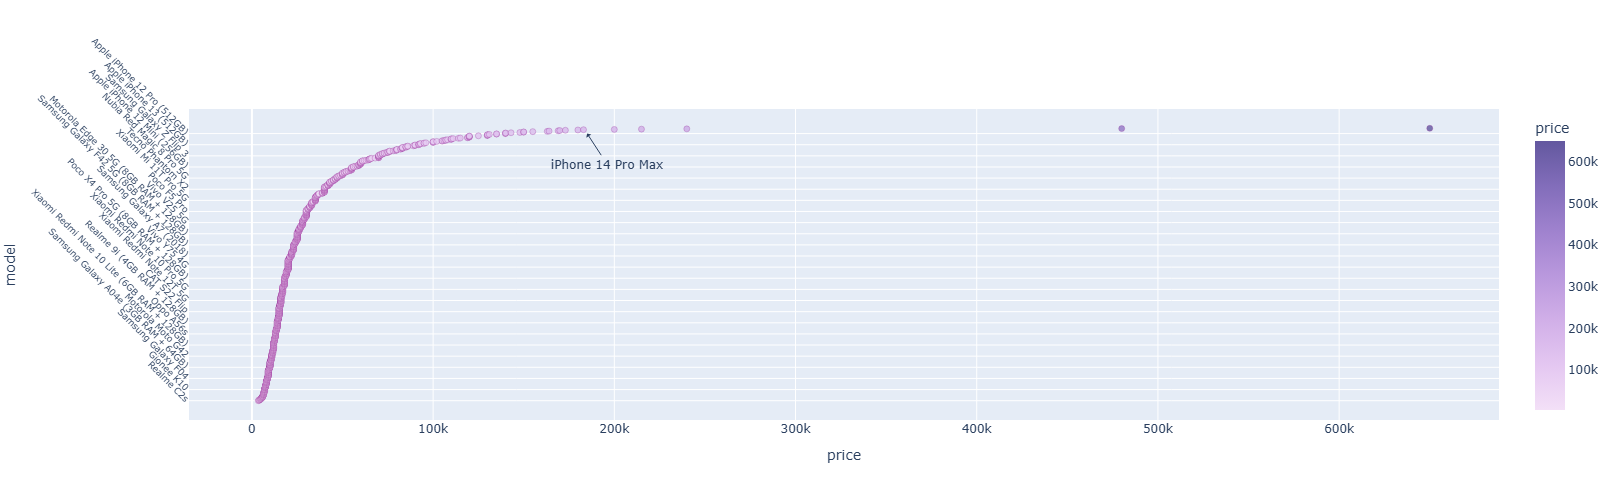

In [833]:
gb5 = smarts.groupby(["model", "brand"]).agg({"price": "mean"}).reset_index()
gb5 = gb5.sort_values(by="price", ascending=False)

g = px.scatter(gb5[::-1], y="model", x="price", color="price", color_continuous_scale="purp")

g.add_annotation(
    text="iPhone 14 Pro Max",
    x=185000, 
    y=960,
    ax=196000,
    ay=850,
    showarrow=True,
    arrowhead=1,
    xref='x',
    yref='y',
    axref='x',
    ayref='y',    
)
g.update_layout({"height": 500, 
                 "yaxis": {"tickangle": 45, "tickfont": {"size": 9}}}).update_traces(marker={"line": {"width": 0}, "opacity": 0.8}).update_traces({"marker":{"line": {"width": 0.3, "color": "purple"}}})

In [821]:
smarts[smarts["model"]=="Vertu Signature Touch"]

brand                  model   price  avg_rating  processor_speed  \
732  vertu  Vertu Signature Touch  650000         6.2              1.5   

     battery_capacity  primary_camera_rear  total_res  
732            2275.0                 13.0    2073600

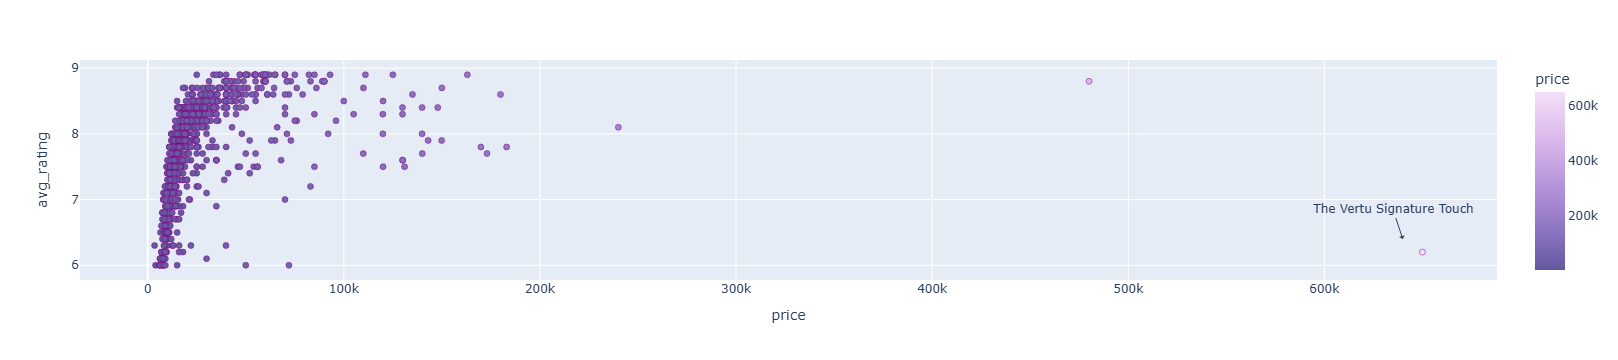

In [847]:
g = px.scatter(smarts, y="avg_rating", x="price", color="price", color_continuous_scale=px.colors.sequential.Purp[::-1]).update_traces({"marker":{"line": {"width": .5, "color": "purple"}}}).update_layout({"width": 550})

g.add_annotation(
    x=640000, 
    y=6.4,
    showarrow=True,
    arrowhead=1,
    text="The Vertu Signature Touch"
)

# Step 8: What is the fastest phone?

Units range from 1.20 - 3.22.


In [615]:
gb6 = smarts.groupby(["model", "brand"]).agg({"processor_speed": "mean"}).sort_values(by="processor_speed", ascending=False).reset_index()

gb6[:20]

model    brand  processor_speed
0                   Apple iPhone 14    apple             3.22
1   Apple iPhone 13 Pro Max (256GB)    apple             3.22
2           Apple iPhone 14 (256GB)    apple             3.22
3           Apple iPhone 14 (512GB)    apple             3.22
4       Apple iPhone 13 Pro (256GB)    apple             3.22
5           Apple iPhone 13 Pro Max    apple             3.22
6         Apple iPhone 13 Pro (1TB)    apple             3.22
7      Apple iPhone 14 Plus (256GB)    apple             3.22
8     Apple iPhone 13 Pro Max (1TB)    apple             3.22
9      Apple iPhone 14 Plus (512GB)    apple             3.22
10             Apple iPhone 14 Plus    apple             3.22
11           Apple iPhone SE 3 2022    apple             3.22
12                  Apple iPhone 13    apple             3.22
13             Apple iPhone 13 Mini    apple             3.22
14                Apple iPhone SE 4    apple             3.22
15              Apple iPhone 13 Pro    apple             3.22
16          Apple iPhone 13 (512GB)    apple             3.22
17          Apple iPhone 13 (256GB)    apple             3.22
18   OnePlus 10T (12GB RAM + 256GB)  oneplus             3.20
19        iQOO Neo 7 Racing Edition     iqoo             3.20

### Answer:

The top processing speed is a 15-way tie at 3.22 - all of Apple products.

However, ***there are 96 other phones with just a slightly slower processor at 3.20***, from companies like OnePlus, Xiaomi, Iqoo, and others.

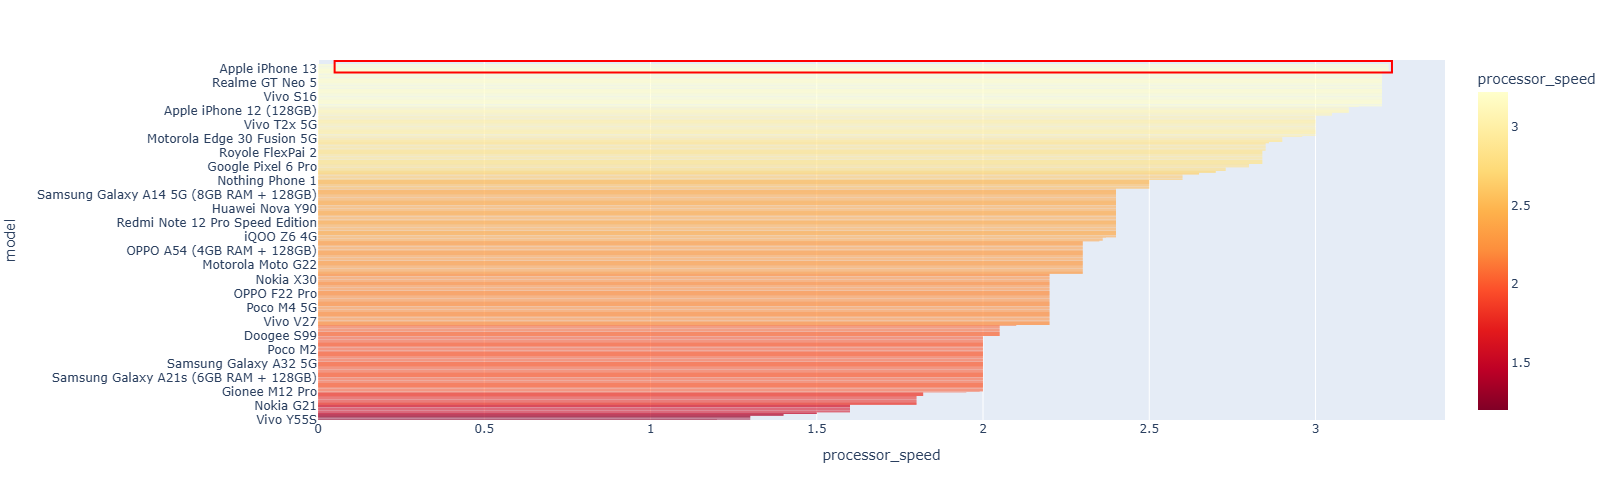

In [848]:
g = px.bar(gb6.dropna()[::-1], y="model", x="processor_speed", color="processor_speed", color_continuous_scale=px.colors.sequential.YlOrRd_r).update_traces(marker={"line": {"width": 0}, "opacity": 1})

g.add_shape(
    type="rect",
    x0=0.05, x1=3.23,
    y0=915, y1=945,
    line={"color": "red"}
).update_layout({"height": 500, "width": 1000})

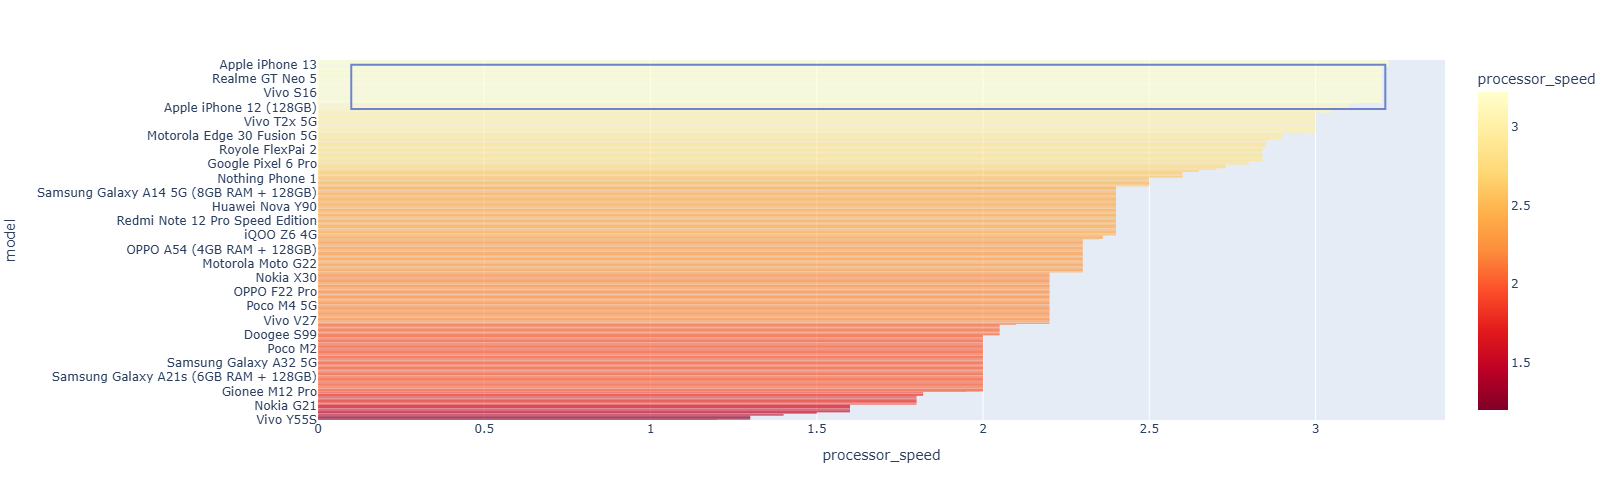

In [849]:
g = px.bar(gb6.dropna()[::-1], y="model", x="processor_speed", color="processor_speed", color_continuous_scale=px.colors.sequential.YlOrRd_r).update_traces(marker={"line": {"width": 0}, "opacity": 1})
g.add_shape(
    type="rect",
    x0=0.1, x1=3.21,
    y0=810, y1=925,
    line={"color": "#6d84c8"}
).update_layout({"height": 500, "width": 1000})

In [689]:
gb6.dropna()[fn_mk][::-1]["processor_speed"].unique(),

(array([3.2 , 3.22]),)

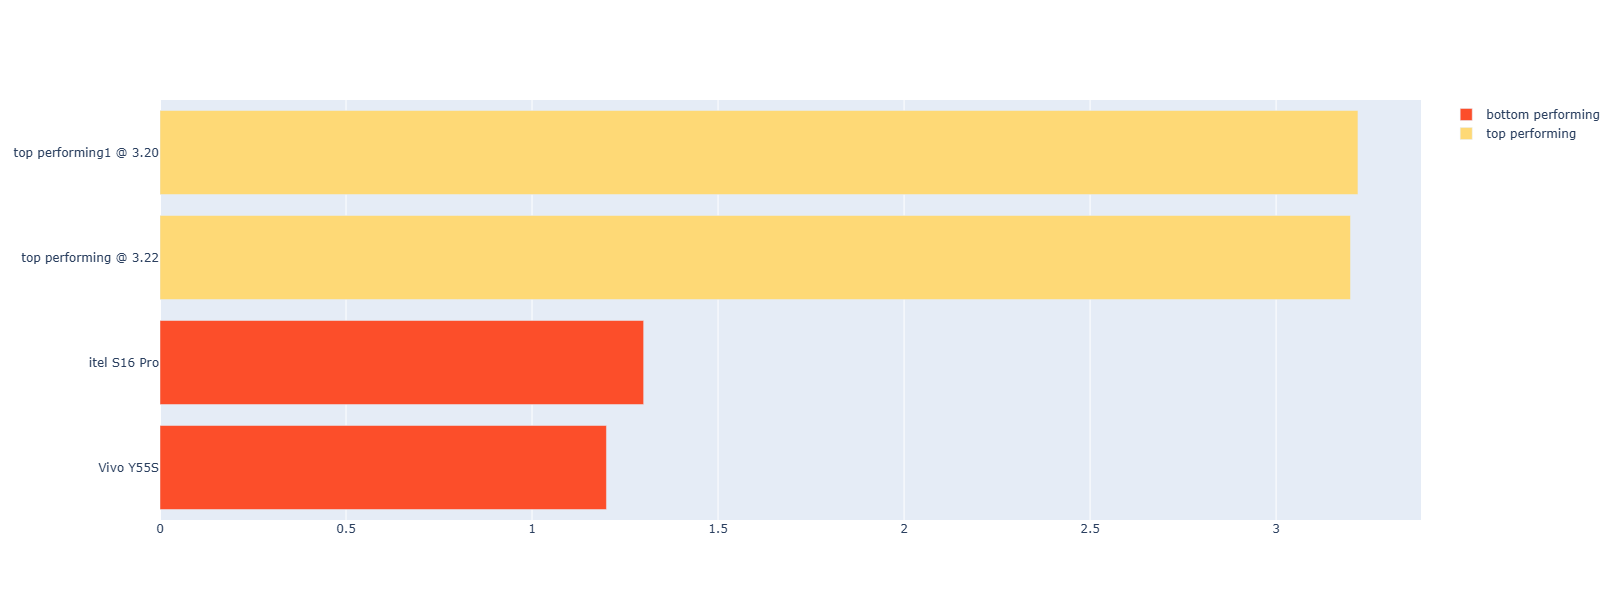

In [850]:
fn_mk = ( gb6["processor_speed"] >= 3.2 )

px.bar(gb6[fn_mk][::-1], y="model", x="processor_speed")

trace0 = go.Bar(
    x=gb6.dropna()[fn_mk][::-1]["processor_speed"].unique(),
    y=["top performing @ 3.22", "top performing1 @ 3.20"],
    orientation="h",
    marker={"color": px.colors.sequential.YlOrRd_r[6]},
    name="top performing"
)
trace1 = go.Bar(
    x=gb6.dropna()[::-1][:2]["processor_speed"],
    y=gb6.dropna()[::-1][:2]["model"],
    orientation="h",
    marker={"color": px.colors.sequential.YlOrRd_r[3]},
    name="bottom performing"
)

go.Figure([trace1, trace0]).update_layout({"height": 600})

 as shown here, the top 2 categories are close enough not to really make a substantial difference. There are 94 models at 3.20, in addition to the 17 at 3.22, which means that 111 models have a very fast processing speed.
 - 15 models == 3.22, all Apple
 - 94 models == 3.20, negligeably different (0.667% percent difference)
     - -> 11.1% of phone models have speeds 3.20 or faster
 - These brands are:
    - 'oneplus', 'iqoo', 'xiaomi', 'asus', 'oppo', 'vivo', 'realme',
        'poco', 'nubia', 'nothing', 'nokia', 'samsung', 'motorola',
        'huawei', 'zte'
    - ***Not just Apple with the fastest phones - even if they'd like to say so!***

In [710]:
pr_mk = ( gb6["processor_speed"] == 3.20 )

len(gb6[pr_mk])

94

The following brands have processng speeds in that 3.20 category bucket.

In [625]:
len(gb6[pr_mk]["brand"].unique()), gb6[pr_mk]["brand"].unique()

(15,
 array(['oneplus', 'iqoo', 'xiaomi', 'asus', 'oppo', 'vivo', 'realme',
        'poco', 'nubia', 'nothing', 'nokia', 'samsung', 'motorola',
        'huawei', 'zte'], dtype=object))

# Step 9: what phone has the best camera?

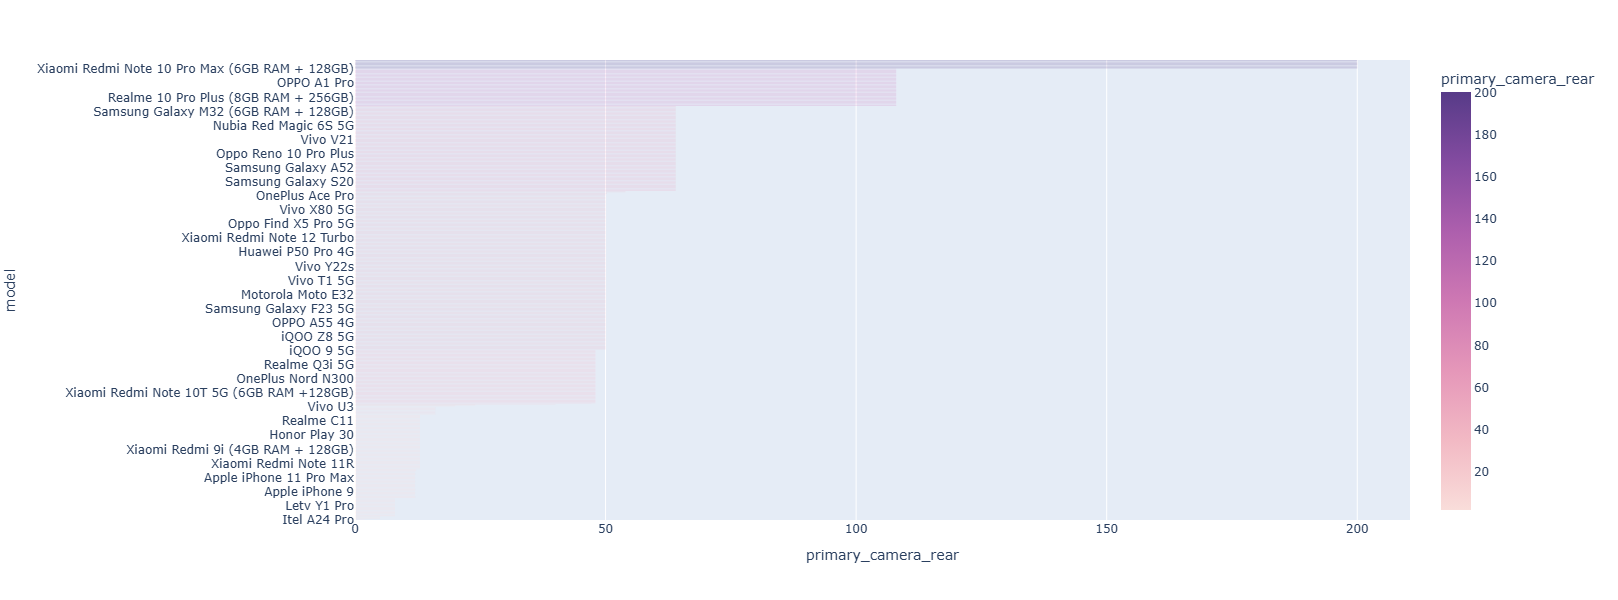

In [852]:
gb7 = smarts.groupby(["model", "brand"]).agg({"primary_camera_rear": "mean"}).sort_values(by="primary_camera_rear", ascending=False).reset_index()
g = px.bar(gb7[::-1], y="model", x="primary_camera_rear", color="primary_camera_rear", color_continuous_scale="purpor").update_traces(marker={"line": {"width": 0}, "opacity": 0.2})
g.update_layout({"height": 600, "width": 1600})

In [452]:
hc_mk = ( gb7["primary_camera_rear"] == 200 )
gb7[hc_mk]["brand"].unique()

array(['nokia', 'xiaomi', 'samsung', 'motorola', 'infinix', 'honor'],
      dtype=object)

### Answer

A 17-way tie among different models with 200 megapixels. AFter that, there is a steep drop off to 108 megapixels.

***Brands with the best camera include:***
- 'nokia',
- 'xiaomi',
- 'samsung',
- 'motorola',
- 'infinix',
- 'honor'

and notably, ***not Apple.***

In [627]:
gb7[:20]

model     brand  \
0                                       Nokia N73 5G     nokia   
1                                       Nokia X60 5G     nokia   
2             Xiaomi Redmi Note 12 Discovery Edition    xiaomi   
3                      Xiaomi Redmi Note 12 Explorer    xiaomi   
4                           Samsung Galaxy S24 Ultra   samsung   
5                                   Nokia X60 Pro 5G     nokia   
6                             Motorola Edge 30 Ultra  motorola   
7          Motorola Edge 30 Ultra (12GB RAM + 256GB)  motorola   
8                              Motorola Moto X30 Pro  motorola   
9                         Motorola Moto Edge X30 Pro  motorola   
10                       Samsung Galaxy S23 Ultra 5G   samsung   
11                                Infinix Zero Ultra   infinix   
12                     Xiaomi Redmi Note 12 Pro Plus    xiaomi   
13  Xiaomi Redmi Note 12 Pro Plus (12GB RAM + 256GB)    xiaomi   
14   Xiaomi Redmi Note 12 Pro Plus (6GB RAM + 128GB)    xiaomi   
15                                 Honor 80 Pro Plus     honor   
16                                 Xiaomi 12T Pro 5G    xiaomi   
17                   Samsung Galaxy Note 30 Ultra 5G   samsung   
18                              OnePlus Nord CE 3 5G   oneplus   
19    Xiaomi Redmi Note 10 Pro Max (6GB RAM + 128GB)    xiaomi   

    primary_camera_rear  
0                 200.0  
1                 200.0  
2                 200.0  
3                 200.0  
4                 200.0  
5                 200.0  
6                 200.0  
7                 200.0  
8                 200.0  
9                 200.0  
10                200.0  
11                200.0  
12                200.0  
13                200.0  
14                200.0  
15                200.0  
16                200.0  
17                200.0  
18                108.0  
19                108.0

# Step 10: What phone model has the best resolution?
*this is an engineered feature, calculated by multiplying pixels height x pixels width.

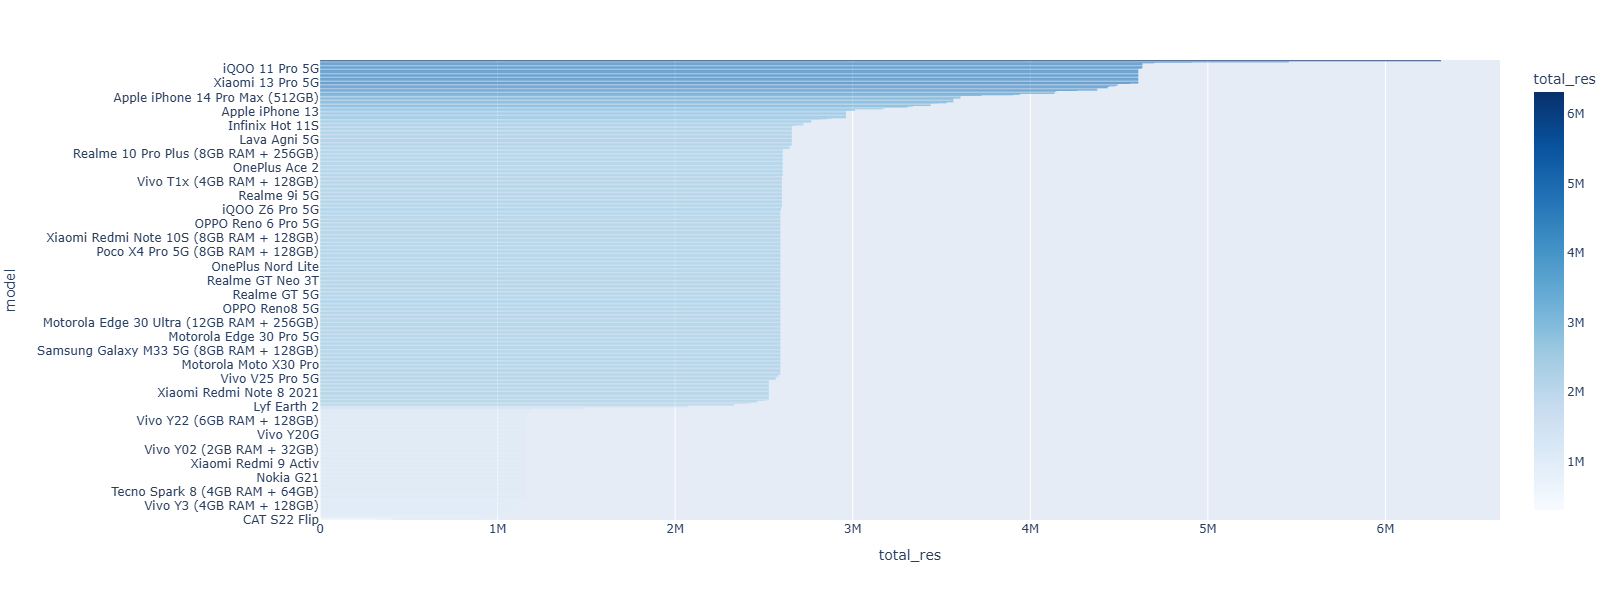

In [853]:
gb8 = smarts.groupby(["model", "brand"]).agg({"total_res": "mean"}).reset_index().sort_values(by="total_res", ascending=False)
g = px.bar(gb8[::-1], y="model", x="total_res", color="total_res", color_continuous_scale="blues").update_traces(marker={"line": {"width": 0}, "opacity": 0.8})
g.update_layout({"height": 600, "width": 1600})

In [630]:
gb8[:5]

model   brand  total_res
646  Sony Xperia 1 IV (12GB RAM + 512GB)    sony  6312960.0
645                     Sony Xperia 1 II    sony  6312960.0
653                    Sony Xperia Pro-I    sony  6312960.0
95                         Huawei Mate X  huawei  5456000.0
96                      Huawei Mate Xs 2  huawei  5456000.0

### Answer

Sony owns all models with the highest resolution. The model of phone is the Sony Xperia. 

This is another good example of smartphone brands specializing.


In [856]:
idx = smart[smart["brand"]=="sony"].filter(regex="\w*[Xperia]w\*", axis=1).index
smarts.loc[idx, ::].sort_values(by="total_res", ascending=False)

brand                                model   price  avg_rating  \
688  sony                     Sony Xperia 1 II   69999         8.9   
689  sony  Sony Xperia 1 IV (12GB RAM + 512GB)   92980         NaN   
696  sony                    Sony Xperia Pro-I  134999         NaN   
691  sony           Sony Xperia 10 III Lite 5G   30990         7.8   
690  sony                    Sony Xperia 10 II   27999         7.5   
692  sony                     Sony Xperia 5 II   69990         8.6   
693  sony                  Sony Xperia 5 IV 5G   82199         8.9   
694  sony                   Sony Xperia Ace IV   19990         8.0   
695  sony                    Sony Xperia L5 5G   15990         7.3   

     processor_speed  battery_capacity  primary_camera_rear  total_res  
688             2.84            4000.0                 12.0    6312960  
689             3.00            5000.0                 12.0    6312960  
696             2.84            4500.0                 12.0    6312960  
691             2.00            4500.0                 12.0    2721600  
690             2.00            3600.0                 12.0    2721600  
692             2.84            4000.0                 12.0    2721600  
693             3.00            5000.0                 12.0    2721600  
694             2.00            5000.0                 50.0    2592000  
695             2.30            4000.0                 13.0    1209600

# Step 11: Best battery capacity

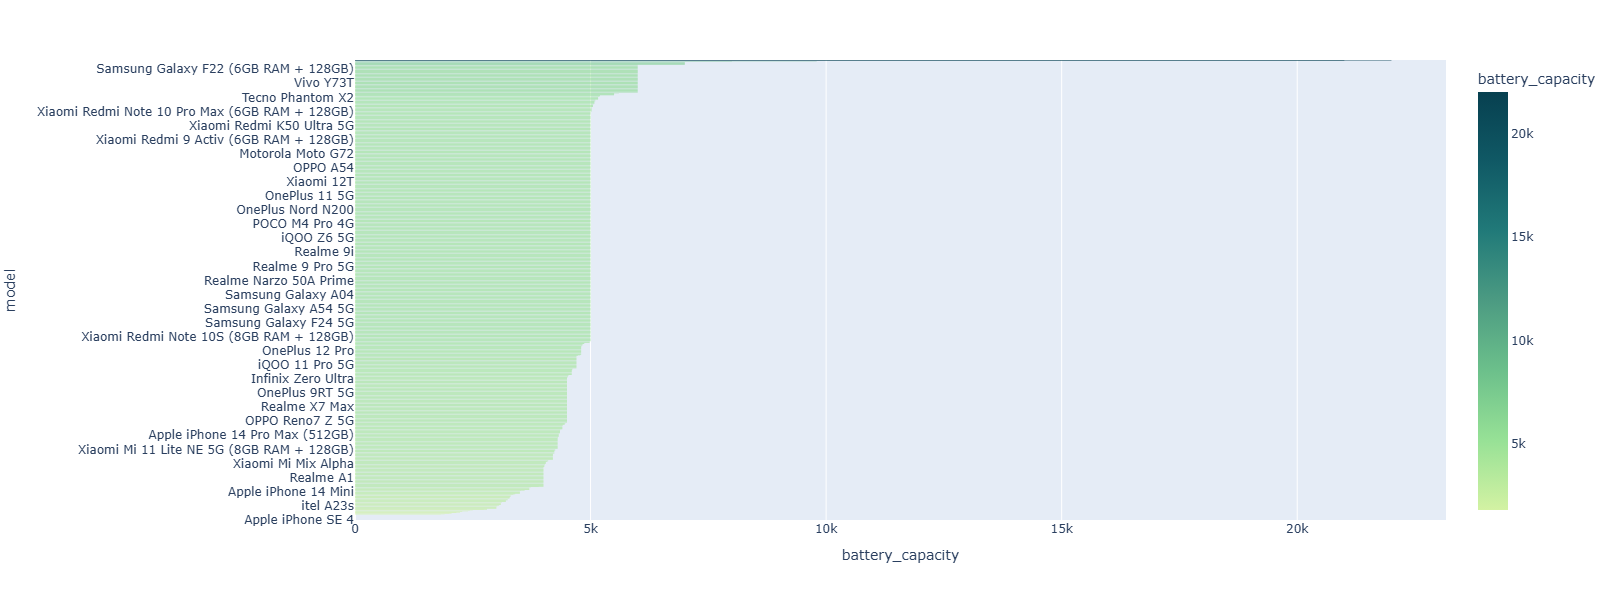

In [857]:
gb9 = smarts.groupby(["model", "brand"]).agg({"battery_capacity": "mean"}).reset_index().sort_values(by="battery_capacity", ascending=False)
g = px.bar(gb9[::-1], y="model", x="battery_capacity", color="battery_capacity", color_continuous_scale="Emrld").update_traces(marker={"line": {"width": 0}, "opacity": 0.8})
g.update_layout({"height": 600, "width": 1600})

In [631]:
gb9[:5]

model    brand  battery_capacity
58       Doogee V Max   doogee           22000.0
366      Oukitel WP19  oukitel           21000.0
367      Oukitel WP21  oukitel            9800.0
368       Oukitel WP9  oukitel            8000.0
674  Tecno Pova Neo 2    tecno            7000.0

### Answer

The Doogee V Max has the best battery capacity, with the Ouitel WP19 coming in at a close second.
- The next largest battery is less tha 50% of these top two models.
- It appears that the brand Doogee specializes in long battery life.

# Conclusions


1. Apple not market leader by many measurements
    - some specs
        - battery life
        - camera
        - resolution
    - as well as ratings
    - yet is still one of the most expensive
2. Other "Top Tier" brands very much so present and popular
    - Samsung
    - Haiwei
    - Xiaomi
4. "Consistency" brands are mostly local
    - these are the brands that consistently produce highly rated phones in the market (highest pure mean of all phones)
    - OnePlus leads in this measurement
    - 4/5 of "Consistency" brands are local to Asia
        - OnePlus, Iqoo, Xiaomi, Motorola, Huawei
5. Experimental forays
    - Leitz: Germany camera company; Tesla: car company
    - Points to the competitive nature of the market
6. Specialization
    - for some of the specs, there is one brand that is the best at that spec
        - battery: Doogee
        - resolution: Sony
        - foldable: Royole
7. "Niche" branding
    - sometimes as differentiating as a spec, sometimes combined
        - "high end luxury" + price (+ real time assistant avialable): Vertu
        - "rugged" + best battery life: Doogee
        - "minimalism": Nothing phone

In [760]:
###################################################################################################################################################

Bonus data vis: How much are people paying for their processors? Color as processor speed.

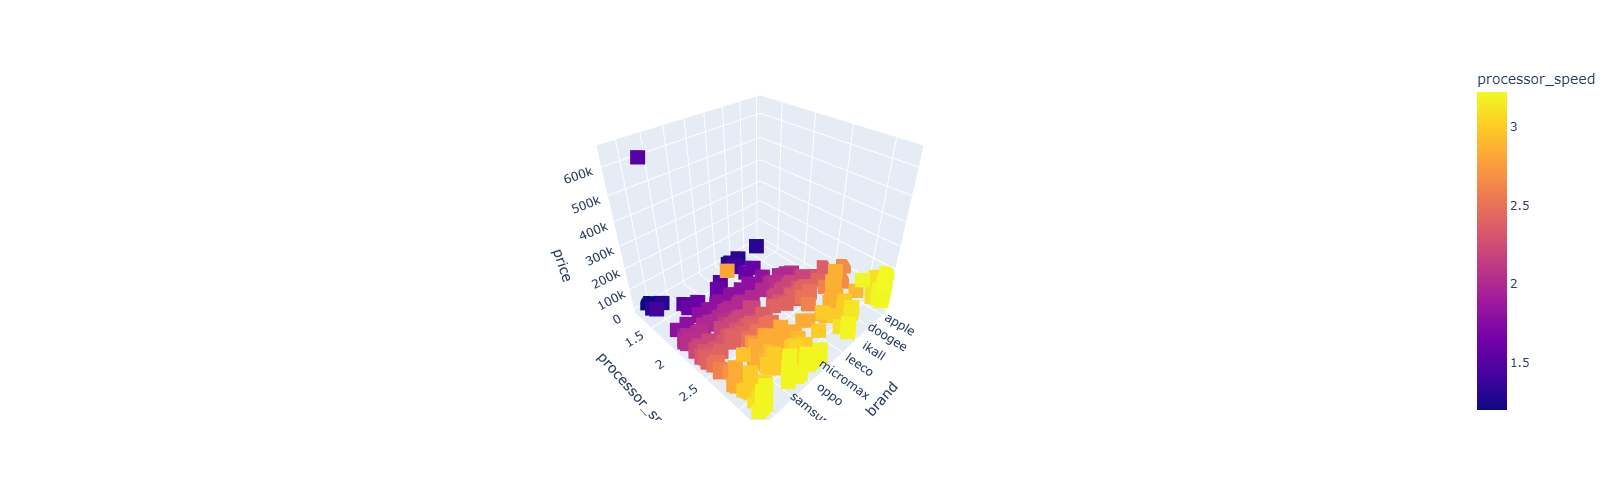

In [858]:
px.scatter_3d(smart, x="brand", y="processor_speed", z="price", color="processor_speed", symbol_sequence=["square"]).update_layout({"height":500})

In [790]:
pr_mk = ( smart["processor_speed"] >= 3.2)
na_mk = ( smart["brand"] != "apple" ) 
smarts[pr_mk & na_mk].sort_values(by="price", ascending=True)

brand                                      model   price  avg_rating  \
978       zte                               ZTE Axon 30S   19999         8.2   
214  motorola                            Motorola Edge S   22490         8.7   
152      iqoo                           iQOO Neo 6 SE 5G   22990         8.3   
869    xiaomi                              Xiaomi Mi 11X   23890         8.0   
141      iqoo                                     iQOO 7   24990         8.3   
748      vivo                                 Vivo T2 5G   24990         8.5   
519    realme                           Realme GT Neo 3T   24999         7.9   
870    xiaomi         Xiaomi Mi 11X 5G (8GB RAM + 128GB)   25990         8.3   
419      poco                                 Poco F4 5G   25999         8.2   
520    realme         Realme GT Neo 3T (8GB RAM + 128GB)   26499         8.1   
420      poco               Poco F4 5G (8GB RAM + 128GB)   27999         8.5   
521    realme         Realme GT Neo 3T (8GB RAM + 256GB)   28499         8.2   
150      iqoo                              iQOO Neo 6 5G   28999         8.2   
450      poco                                 POCO X5 GT   29990         8.4   
734      vivo                                   Vivo S16   29990         8.5   
914    xiaomi                           Xiaomi Redmi K60   29990         8.4   
418      poco                 Poco F4 (12GB RAM + 256GB)   29999         8.6   
424      poco                                Poco F5 Pro   29999         8.4   
524    realme                          Realme GT Neo2 5G   31999         8.2   
154      iqoo                  iQOO Neo 7 Racing Edition   32990         8.4   
516    realme          Realme GT Explorer Master Edition   32990         8.5   
151      iqoo           iQOO Neo 6 5G (12GB RAM + 256GB)   33749         8.4   
422      poco                                    Poco F5   34990         8.5   
523    realme                            Realme GT Neo 5   34999         8.3   
296   oneplus                              OnePlus Ace 2   34999         8.4   
278     nubia                                  Nubia Z50   34999         8.2   
142      iqoo                  iQOO 7 (12GB RAM + 256GB)   35990         8.5   
916    xiaomi                       Xiaomi Redmi K60 Pro   38999         8.5   
266     nokia                               Nokia X60 5G   39990         8.7   
608   samsung                      Samsung Galaxy A83 5G   39990         8.6   
272   nothing                            Nothing Phone 2   39990         8.8   
911    xiaomi                  Xiaomi Redmi K50 Ultra 5G   39999         8.5   
290   oneplus                                OnePlus 11R   39999         8.5   
251  motorola                          Motorola Moto X40   39999         8.9   
512    realme        Realme GT 2 Explorer Master Edition   40990         8.6   
250  motorola                      Motorola Moto X30 Pro   41990         NaN   
211  motorola                    Motorola Edge 40 Fusion   42990         8.7   
776      vivo                               Vivo V26 Pro   42990         8.7   
778      vivo                               Vivo V27 Pro   43999         8.7   
392      oppo                    OPPO Reno 6 Pro Plus 5G   44990         8.7   
285   oneplus                                OnePlus 10T   44999         8.5   
402      oppo                       OPPO Reno 9 Pro Plus   45999         8.6   
275     nubia                   Nubia Red Magic 8 Pro 5G   46990         8.4   
855    xiaomi                               Xiaomi 13 5G   46990         8.9   
149      iqoo                                 iQOO 9T 5G   47990         8.5   
298   oneplus                            OnePlus Ace Pro   47990         8.6   
254  motorola                        Motorola ThinkPhone   49990         8.9   
267     nokia                           Nokia X60 Pro 5G   49990         NaN   
286   oneplus             OnePlus 10T (12GB RAM + 256GB)   50999         8.7   
915    x